In [2]:
#Importing
#!conda install geopandas --y
#!conda install imbalanced-learn --y
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import tensorflow as tf
import geopandas as gpd

from shapely.geometry import Point

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.tools import add_constant
from statsmodels.robust.robust_linear_model import RLM

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, 
mean_absolute_error, mean_squared_error)
from sklearn.feature_selection import RFECV, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from scikeras.wrappers import KerasClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Input, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [3]:
#Importing Data
data = pd.read_csv("data/ACLED2021-2024.csv")

location_data = data.copy()

data.drop(columns=['event_type', 'source', 'notes', 'time_precision', 'assoc_actor_1', 'assoc_actor_2', 'iso', 'region', 'admin3', 'location', 
                  'latitude', 'longitude', 'geo_precision', 'source_scale', 'timestamp', 'tags', 'population_best', 'event_id_cnty'], 
          inplace=True)

print(data.shape)


data['event_date'] = pd.to_datetime(data['event_date'], errors = 'coerce') #changing to datetime
data = data.sort_values('event_date', ascending=True)
#data.set_index('event_date', inplace=True)
#data.index = pd.to_datetime(data.index)
print(data.shape)
#data = data.dropna(subset=['event_date'])
#print(data.shape)

(38130, 14)
(38130, 14)


In [4]:
# Dropping Dupes
initial_row_count = data.shape[0]
data = data.drop_duplicates()
final_row_count = data.shape[0]
print(f"Removed {initial_row_count - final_row_count} duplicates")
print(data.shape)

Removed 9878 duplicates
(28252, 14)


In [5]:
#Reformatting / Cleaning

#Addressing NA values - Categorical, NUmerical and date
categorical_columns = ['disorder_type',  'sub_event_type', 'actor1', 'actor2', 'civilian_targeting', 
                       'country', 'admin1', 'admin2'] #'source', 'notes', 'event_type'
categorical_columns = data[categorical_columns]


for column in categorical_columns:
    data[column] = data[column].fillna('Not specified')

numerical_columns = ['fatalities', 'inter1', 'inter2', 'interaction']

for column in numerical_columns:
    data[column] = data[column].fillna(data[column].median()) #using median to fill

#print(data.isna().sum())
print(data.shape)
#data.loc[:, 'actor2'] = data['actor2'].fillna('Not specified')
#data.loc[:, 'civilian_targeting'] = data['civilian_targeting'].fillna('Not specified')

(28252, 14)


In [6]:
#Grouping Together Actor1 and 2
def consolidate_names(name):
    if 'Military Forces of Israel' in name:
        return 'Military Forces of Israel'
    elif 'Police Forces of Israel' in name:
        return 'Police Forces of Israel'
    elif 'Hamas Movement' in name:
        return 'Hamas Movement'
    elif 'Police Forces of Israel' in name or 'Government of Israel' in name:
        return 'Government and Police Forces of Israel'
    elif 'Police Forces of Palestine' in name or 'Government of Palestine' in name:
        return 'Government and Police Forces of Palestine'
    elif 'PIJ:' in name or 'Islamic Jihad' in name:
        return 'Palestinian Islamic Jihad'
    elif 'Hezbollah' in name:
        return 'Hezbollah'
    elif 'Al Aqsa' in name:
        return 'Al Aqsa Martyrs Brigade'
    elif 'Katibat' in name:
        return 'Katibat Groups (Palestine)'
    elif 'PFLP:' in name:
        return 'Popular Front for the Liberation of Palestine'
    elif 'DFLP:' in name:
        return 'Democratic Front for the Liberation of Palestine'
    elif 'Military Forces of Iran' in name:
        return 'Iranian Revolutionary Guard Corps'
    elif 'Islamic State' in name:
        return 'Islamic State'
#civilians
    elif 'Civilians' in name:
        if 'Israel' in name or 'Palestine' in name:
            return name  #Keeping isr and pal civilians
        else:
            return 'Civilians (International)'  # grouping others as int.
#armed groups
    elif 'Unidentified Armed Group' in name:
        if 'Israel' in name or 'Palestine' in name:
            return name  
        else:
            return 'Unidentified Armed Group (International)'
#military forces
    elif 'Military Forces of' in name:
        if 'Israel' in name or 'Palestine' in name:
            return name  
        else:
            return 'Military Forces of International Forces'
    elif 'Settlers' in name:
        return 'Settlers (Israel)'
    elif 'Protesters' in name or 'Rioters' in name:
        return name  # Retains specific categories due to their distinct contexts
    else:
        return name #'Other Groups' 

# Apply the consolidation function to both actor1 and actor2
data['actor1_grouped'] = data['actor1'].apply(consolidate_names)
data['actor2_grouped'] = data['actor2'].apply(consolidate_names)

In [7]:
#Grouping smaller entities
actor1_counts = data['actor1_grouped'].value_counts()
actor2_counts = data['actor2_grouped'].value_counts()

def consolidate_small_groups(name, counts): #Check if Isr or Pal if not 'name'
    if counts[name] < 10:
        if 'Israel' in name:
            return 'Other (Israel)'
        elif 'Palestine' in name:
            return 'Other (Palestine)'
        else:
            return'Other Group'
    else:
        # Return the name if the count is 10 or more
        return name

# Apply the consolidation function to both actor1_grouped and actor2_grouped
data['actor1_grouped'] = data['actor1_grouped'].apply(lambda x: consolidate_small_groups(x, actor1_counts))
data['actor2_grouped'] = data['actor2_grouped'].apply(lambda x: consolidate_small_groups(x, actor2_counts))


# Print the new value counts to confirm re-categorization
#print(data['actor1_grouped'].value_counts())
#print(data['actor2_grouped'].value_counts())

data['actor1'] = data['actor1_grouped']
data['actor2'] = data['actor2_grouped']

data.drop(['actor1_grouped', 'actor2_grouped'], axis=1, inplace=True)
print(data.isna().sum())
# calculate the percentage of zero values per column
zero_counts = (data == 0).astype(int).sum(axis=0)
zero_percentage = 100 * zero_counts / len(data)

# display the columns with high percentages of zeros
print("Percentage of zeros in each column:")
print(zero_percentage[zero_percentage > 0])  # Adjust the threshold as necessary


event_date            0
year                  0
disorder_type         0
sub_event_type        0
actor1                0
inter1                0
actor2                0
inter2                0
interaction           0
civilian_targeting    0
country               0
admin1                0
admin2                0
fatalities            0
dtype: int64
Percentage of zeros in each column:
inter2        24.720374
fatalities    88.906980
dtype: float64


In [8]:
#Creating Temporal Features for T-S

#Date related
data['year'] = data['event_date'].dt.year
data['month'] = data['event_date'].dt.month
data['day'] = data['event_date'].dt.day
data['day_of_week'] = data['event_date'].dt.day_name()
data['days_since_start'] = (data['event_date'] - data['event_date'].min()).dt.days

# time since last event of the same type
data['time_since_last_event'] = data.groupby('sub_event_type')['event_date'].diff().dt.days
#data['time_since_last_event'] = data.groupby('event_type').apply(lambda x: x.index.to_series().diff().dt.days).reset_index(level=0, drop=True)


# time since last disorder of the same type
data['time_since_last_disorder'] = data.groupby('disorder_type')['event_date'].diff().dt.days
#data['time_since_last_disorder'] = data.groupby('disorder_type').apply(lambda x: x.index.to_series().diff().dt.days).reset_index(level=0, drop=True)
#print(data[['time_since_last_event', 'time_since_last_disorder']].head())


# rolling avg for fatalities
data['rolling_avg_fatalities_7d'] = data.groupby(
    'sub_event_type')['fatalities'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())


# cumulative counts of events and fatalities by specific features
data['cumulative_sub_events'] = data.groupby(['sub_event_type']).cumcount() + 1
data['cumulative_fatalities'] = data.groupby(['sub_event_type'])['fatalities'].cumsum()

log_data = data.copy()


In [9]:
#All data cleaning steps on LOCATION DATA
location_data['event_date'] = pd.to_datetime(location_data['event_date'], errors='coerce')  # Convert to datetime

location_data.sort_index(inplace=True)

# Drop duplicates and record the count before and after
initial_row_count = location_data.shape[0]
location_data.drop_duplicates(inplace=True)
final_row_count = location_data.shape[0]

# Fill missing categorical data
categorical_columns = ['disorder_type', 'event_type', 'sub_event_type', 'actor1', 'actor2', 'civilian_targeting', 
                       'country', 'admin1', 'admin2', 'source', 'notes']
for column in categorical_columns:
    location_data[column] = location_data[column].fillna('Not specified')
    
# Fill missing numerical data
numerical_columns = ['fatalities', 'inter1', 'inter2', 'interaction', 'longitude', 'latitude']
for column in numerical_columns:
    location_data[column] = location_data[column].fillna(location_data[column].median())

# Assume consolidate_names is a function that's already defined
location_data['actor1_grouped'] = location_data['actor1'].apply(consolidate_names)
location_data['actor2_grouped'] = location_data['actor2'].apply(consolidate_names)

# Calculate value counts for grouped actors
actor1_counts = location_data['actor1_grouped'].value_counts()
actor2_counts = location_data['actor2_grouped'].value_counts()

# Assume consolidate_small_groups is a function that's already defined
# Apply consolidation function based on counts
location_data['actor1_grouped'] = location_data['actor1_grouped'].apply(lambda x: consolidate_small_groups(x, actor1_counts))
location_data['actor2_grouped'] = location_data['actor2_grouped'].apply(lambda x: consolidate_small_groups(x, actor2_counts))

# Update the 'actor1' and 'actor2' columns
location_data['actor1'] = location_data['actor1_grouped']
location_data['actor2'] = location_data['actor2_grouped']

# Drop the temporary grouped columns
location_data.drop(['actor1_grouped', 'actor2_grouped'], axis=1, inplace=True)

<Figure size 1500x800 with 0 Axes>

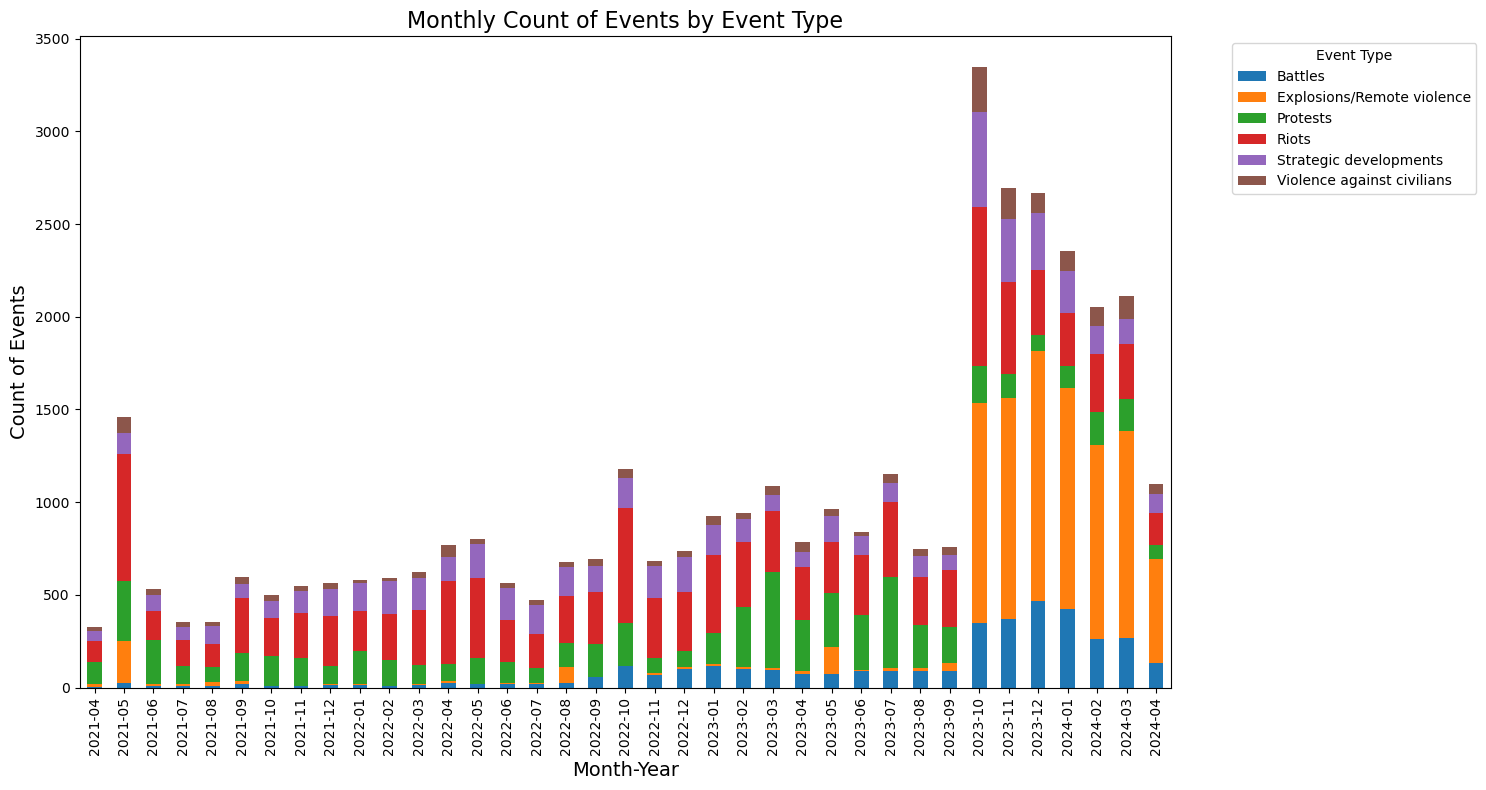

In [10]:
# Plotting the count of events over time by event_type
location_data['month_year'] = location_data['event_date'].dt.to_period('M') #group data into month

# countplot with monthly data
plt.figure(figsize=(15, 8))
monthly_data = location_data.groupby(['month_year', 'event_type']).size().reset_index(name='counts')

#creating'event_type' columns
monthly_pivot = monthly_data.pivot(index='month_year', columns='event_type', values='counts').fillna(0)

monthly_pivot.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Monthly Count of Events by Event Type', fontsize=16)
plt.xlabel('Month-Year', fontsize=14)
plt.ylabel('Count of Events', fontsize=14)
plt.xticks(rotation=90)
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

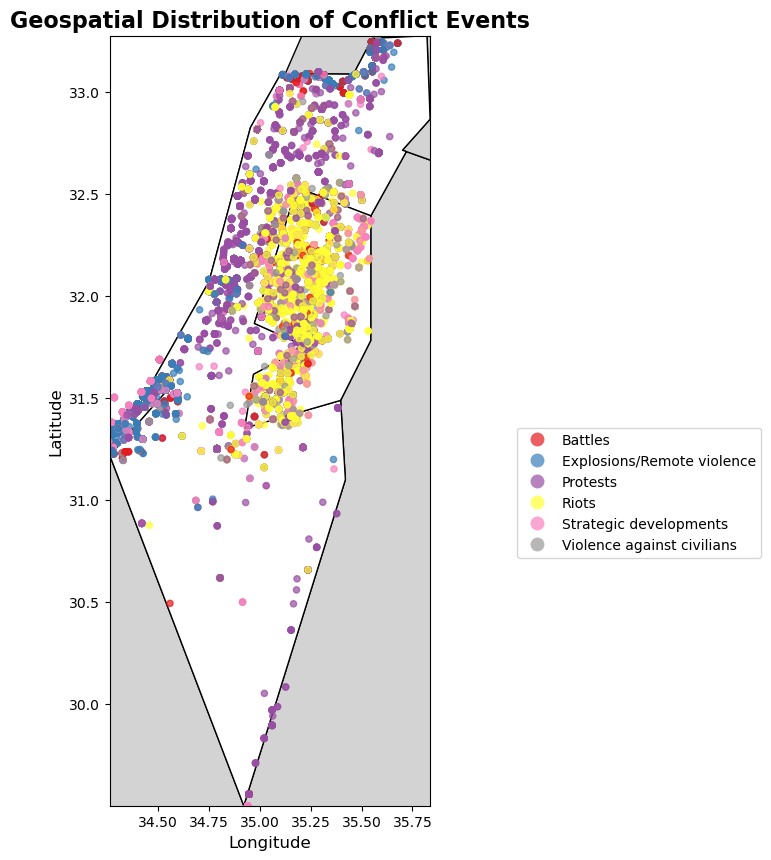

In [11]:
geometry = [Point(xy) for xy in zip(location_data.longitude, location_data.latitude)]
geo_df = gpd.GeoDataFrame(location_data, geometry=geometry)

fig, ax = plt.subplots(1, 1, figsize=(5, 10))

# Load a world map shapefile and plot the world in a light grey
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot Israel and Palestine with a clear edge
isr_pal = world[(world.name == "Israel") | (world.name == "Palestine")]
isr_pal.plot(ax=ax, color='white', edgecolor='black')

geo_df.plot(ax=ax, column='event_type', legend=True, markersize=20, cmap='Set1', alpha=0.7)

leg = ax.get_legend()
if leg:  
    leg.set_bbox_to_anchor((1.25, 0.5))

# Set the limits to frame the region of interest
plt.xlim(isr_pal.bounds.minx.min(), isr_pal.bounds.maxx.max())
plt.ylim(isr_pal.bounds.miny.min(), isr_pal.bounds.maxy.max())

# Set title and axis labels
plt.title('Geospatial Distribution of Conflict Events', fontsize=16, weight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Remove axis for a cleaner look
plt.axis('on')

# Show the plot
plt.show()

In [12]:
#log transformations
log_columns = ['fatalities', 'cumulative_sub_events', 'cumulative_fatalities', 'rolling_avg_fatalities_7d', 
               'time_since_last_event', 'time_since_last_disorder', 'days_since_start']
for col in log_columns:
    log_data['log_' + col] = np.log1p(log_data[col])

# creating lagged features
for col in log_columns:
    log_col = 'log_' + col
    for lag in [1, 2, 3]:
        log_data[f'{log_col}_lag{lag}'] = log_data[log_col].shift(lag)

In [13]:
log_data

event_date  year           disorder_type  \
38129 2021-04-20  2021  Strategic developments   
38117 2021-04-20  2021      Political violence   
38118 2021-04-20  2021          Demonstrations   
38119 2021-04-20  2021          Demonstrations   
38120 2021-04-20  2021      Political violence   
...          ...   ...                     ...   
28    2024-04-19  2024      Political violence   
27    2024-04-19  2024      Political violence   
26    2024-04-19  2024      Political violence   
25    2024-04-19  2024      Political violence   
0     2024-04-19  2024      Political violence   

                          sub_event_type                     actor1  inter1  \
38129       Looting/property destruction             Hamas Movement       3   
38117                       Mob violence           Rioters (Israel)       5   
38118                   Peaceful protest        Protesters (Israel)       6   
38119                   Peaceful protest        Protesters (Israel)       6   
38120                             Attack    Police Forces of Israel       8   
...                                  ...                        ...     ...   
28                      Air/drone strike  Military Forces of Israel       8   
27                      Air/drone strike  Military Forces of Israel       8   
26                      Air/drone strike  Military Forces of Israel       8   
25                      Air/drone strike  Military Forces of Israel       8   
0      Shelling/artillery/missile attack             Hamas Movement       3   

                          actor2  inter2  interaction  civilian_targeting  \
38129  Military Forces of Israel       8           38       Not specified   
38117      Civilians (Palestine)       7           57  Civilian targeting   
38118              Not specified       0           60       Not specified   
38119              Not specified       0           60       Not specified   
38120      Civilians (Palestine)       7           78  Civilian targeting   
...                          ...     ...          ...                 ...   
28         Civilians (Palestine)       7           78  Civilian targeting   
27                 Not specified       0           80       Not specified   
26         Civilians (Palestine)       7           78  Civilian targeting   
25         Civilians (Palestine)       7           78  Civilian targeting   
0                  Not specified       0           30       Not specified   

       ... log_rolling_avg_fatalities_7d_lag3 log_time_since_last_event_lag1  \
38129  ...                                NaN                            NaN   
38117  ...                                NaN                            NaN   
38118  ...                                NaN                            NaN   
38119  ...                           0.000000                            NaN   
38120  ...                           0.000000                            0.0   
...    ...                                ...                            ...   
28     ...                           0.133531                            0.0   
27     ...                           0.133531                            0.0   
26     ...                           0.000000                            0.0   
25     ...                           0.826679                            0.0   
0      ...                           0.826679                            0.0   

      log_time_since_last_event_lag2  log_time_since_last_event_lag3  \
38129                            NaN                             NaN   
38117                            NaN                             NaN   
38118                            NaN                             NaN   
38119                            NaN                             NaN   
38120                            NaN                             NaN   
...                              ...                             ...   
28                               0.0                             0

In [14]:
print(log_data.isna().sum())

# percentage of zero values
zero_counts = (log_data == 0).astype(int).sum(axis=0)
zero_percentage = 100 * zero_counts / len(log_data)
print(zero_percentage[zero_percentage > 0])


event_date                             0
year                                   0
disorder_type                          0
sub_event_type                         0
actor1                                 0
inter1                                 0
actor2                                 0
inter2                                 0
interaction                            0
civilian_targeting                     0
country                                0
admin1                                 0
admin2                                 0
fatalities                             0
month                                  0
day                                    0
day_of_week                            0
days_since_start                       0
time_since_last_event                 20
time_since_last_disorder               4
rolling_avg_fatalities_7d              0
cumulative_sub_events                  0
cumulative_fatalities                  0
log_fatalities                         0
log_cumulative_s

In [15]:
#replacing infinities w NaN
log_data.replace([np.inf, -np.inf], np.nan, inplace=True)
#log_data.fillna(log_data.median(), inplace=True)

#median for numeric columns
numeric_medians = log_data.select_dtypes(include=[np.number]).median()
log_data.fillna(numeric_medians, inplace=True)


log_data['time_since_last_event'].fillna(method='ffill', inplace=True)
log_data['time_since_last_event'].fillna(method='bfill', inplace=True)

lag_cols = [col for col in log_data.columns if ('log_time_since_last_event' in col or 'lag' in col) and 
            np.issubdtype(log_data[col].dtype, np.number)]

In [16]:
print(log_data.shape)
print(log_data.isna().sum())

# percentage of zero values
zero_counts = (log_data == 0).astype(int).sum(axis=0)
zero_percentage = 100 * zero_counts / len(log_data)
print(zero_percentage[zero_percentage > 0])

(28252, 51)
event_date                            0
year                                  0
disorder_type                         0
sub_event_type                        0
actor1                                0
inter1                                0
actor2                                0
inter2                                0
interaction                           0
civilian_targeting                    0
country                               0
admin1                                0
admin2                                0
fatalities                            0
month                                 0
day                                   0
day_of_week                           0
days_since_start                      0
time_since_last_event                 0
time_since_last_disorder              0
rolling_avg_fatalities_7d             0
cumulative_sub_events                 0
cumulative_fatalities                 0
log_fatalities                        0
log_cumulative_sub_events   

In [17]:
threshold = 70

# columns where the percentage of zero is higher than threshold
columns_to_drop = zero_percentage[zero_percentage > threshold].index

# drop
log_data = log_data.drop(columns=columns_to_drop)

print("Columns dropped:", columns_to_drop)
print("Shape of the new DataFrame:", log_data.shape)

Columns dropped: Index(['fatalities', 'time_since_last_event', 'time_since_last_disorder',
       'log_fatalities', 'log_time_since_last_event',
       'log_time_since_last_disorder', 'log_fatalities_lag1',
       'log_fatalities_lag2', 'log_fatalities_lag3',
       'log_time_since_last_event_lag1', 'log_time_since_last_event_lag2',
       'log_time_since_last_event_lag3', 'log_time_since_last_disorder_lag1',
       'log_time_since_last_disorder_lag2',
       'log_time_since_last_disorder_lag3'],
      dtype='object')
Shape of the new DataFrame: (28252, 36)


In [18]:
print(log_data.dtypes)
unique_counts = log_data.nunique()
print(unique_counts)

event_date                            datetime64[ns]
year                                           int32
disorder_type                                 object
sub_event_type                                object
actor1                                        object
inter1                                         int64
actor2                                        object
inter2                                         int64
interaction                                    int64
civilian_targeting                            object
country                                       object
admin1                                        object
admin2                                        object
month                                          int32
day                                            int32
day_of_week                                   object
days_since_start                               int64
rolling_avg_fatalities_7d                    float64
cumulative_sub_events                         

In [19]:
#Encoding

#One-Hot for Categoricals
categorical_cols = ['disorder_type', 'sub_event_type', 'civilian_targeting',
                    'country', 'admin1', 'admin2', 'day_of_week', 'inter1', 'inter2', 'interaction']
log_data_encoded = pd.get_dummies(log_data, columns=categorical_cols)
log_data_encoded

#Label Encoder
label_encoders = {}

for col in ['actor1', 'actor2']:
    le = LabelEncoder()
    log_data_encoded[col] = le.fit_transform(log_data_encoded[col])
    label_encoders[col] = le  # storing the encoder
log_data_encoded.to_csv('data/log_data_encoded.csv', index=False)
#print(log_data_encoded.isna().sum())

log_data_encoded = log_data_encoded.apply(lambda col: col.astype(int) if pd.api.types.is_bool_dtype(col) else col) 
#SO IMPORTANT! changes values of bool to int

In [20]:
log_data_encoded

event_date  year  actor1  actor2  month  day  days_since_start  \
38129 2021-04-20  2021       3       7      4   20                 0   
38117 2021-04-20  2021      19       2      4   20                 0   
38118 2021-04-20  2021      17       9      4   20                 0   
38119 2021-04-20  2021      17       9      4   20                 0   
38120 2021-04-20  2021      14       2      4   20                 0   
...          ...   ...     ...     ...    ...  ...               ...   
28    2024-04-19  2024       8       2      4   19              1095   
27    2024-04-19  2024       8       9      4   19              1095   
26    2024-04-19  2024       8       2      4   19              1095   
25    2024-04-19  2024       8       2      4   19              1095   
0     2024-04-19  2024       3       9      4   19              1095   

       rolling_avg_fatalities_7d  cumulative_sub_events  \
38129                   0.000000                      1   
38117                   0.000000                      1   
38118                   0.000000                      1   
38119                   0.000000                      2   
38120                   0.000000                      1   
...                          ...                    ...   
28                      1.285714                   3002   
27                      1.285714                   3003   
26                      1.285714                   3004   
25                      1.428571                   3005   
0                       0.000000                   2351   

       cumulative_fatalities  ...  interaction_57  interaction_58  \
38129                      0  ...               0               0   
38117                      0  ...               1               0   
38118                      0  ...               0               0   
38119                      0  ...               0               0   
38120                      0  ...               0               0   
...                      ...  ...             ...             ...   
28                     26163  ...               0               0   
27                     26163  ...               0               0   
26                     26163  ...               0               0   
25                     26164  ...               0               0   
0                       2399  ...               0               0   

       interaction_60  interaction_66  interaction_68  interaction_70  \
38129               0               0               0               0   
38117               0               0               0               0   
38118               1               0               0               0   
38119               1               0               0               0   
38120               0               0               0               0   
...               ...             ...             ...             ...   
28                  0               0               0               0   
27                  0               0               0               0   
26                  0               0               0               0   
25                  0               0               0               0   
0                   0               0               0               0   

       interaction_77  interaction_78  interaction_80  interaction_88  
38129               0               0               0               0  
38117               0               0               0               0  
38118               0               0               0               0  
38119               0               0               0               0  
38120               0               1               0               0  
...               ...             ...             ...             ...  
28                  0               1               0               0  
27                  0               0               1               0  
26                  0               1               0               0  
25    

In [21]:
print(log_data_encoded.dtypes)
unique_counts = log_data_encoded.nunique()
#print(unique_counts)

event_date        datetime64[ns]
year                       int32
actor1                     int64
actor2                     int64
month                      int32
                       ...      
interaction_70             int64
interaction_77             int64
interaction_78             int64
interaction_80             int64
interaction_88             int64
Length: 146, dtype: object


In [25]:
# Correlation Analysis for numerical cols
numerical_cols = log_data_encoded.select_dtypes(include=['int64', 'float64']).columns
numerical_data = log_data_encoded[numerical_cols]
correlation_matrix = numerical_data.corr()
correlation_matrix

threshold = 0.75
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print(to_drop)
print(log_data_encoded.shape)

[]
(28252, 122)


In [26]:
# target columns
sub_event_type_columns = [col for col in log_data_encoded.columns if col.startswith('sub_event_type_')]

# taking out the features, datetime
features = log_data_encoded.drop(columns=['event_date'] + sub_event_type_columns)

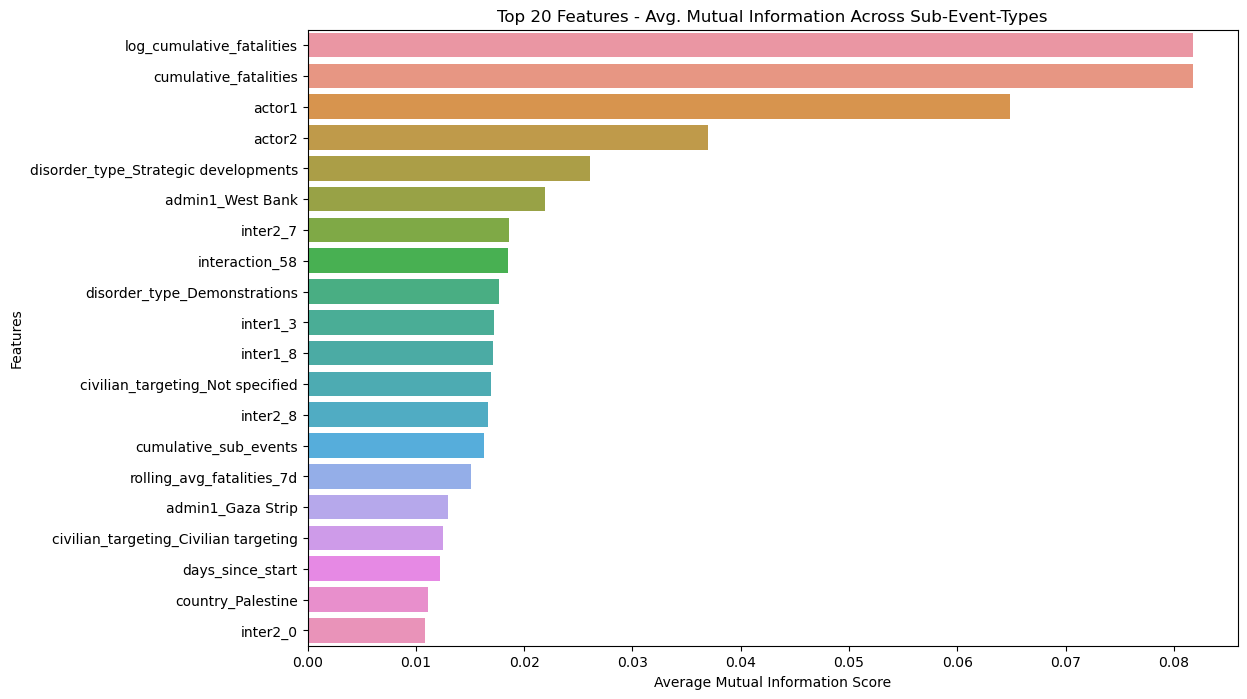

In [27]:
#Mututal Information features

# actual mi score calculation
mi_scores_df = pd.DataFrame()

for target in sub_event_type_columns:
    mi_scores = mutual_info_classif(features, log_data_encoded[target], discrete_features='auto')
    mi_scores_df[target] = mi_scores

#creating mi_scores + top 20 features shown below
mi_scores_df['average_mi_score'] = mi_scores_df.mean(axis=1)
mi_scores_df['feature'] = features.columns

#if 'feature' in mi_scores_df.columns:
    #top_features_mi = mi_scores_df.sort_values('average_mi_score', ascending=False).head(20)['feature'].tolist()
#else:
    #top_features_mi = mi_scores_df.sort_values('average_mi_score', ascending=False).head(20).index.tolist()

plt.figure(figsize=(12, 8))
sns.barplot(x='average_mi_score', y='feature', data=mi_scores_df.sort_values('average_mi_score', ascending=False).head(20))
plt.title('Top 20 Features - Avg. Mutual Information Across Sub-Event-Types')
plt.xlabel('Average Mutual Information Score')
plt.ylabel('Features')
plt.show()

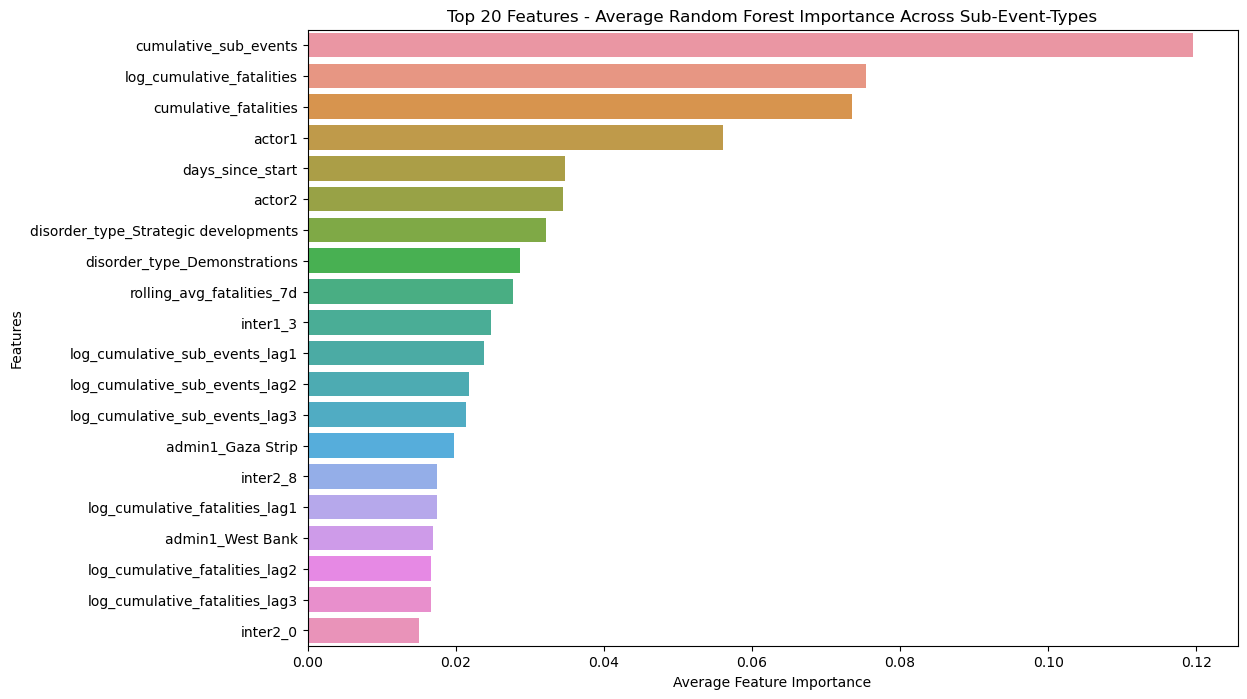

In [28]:
#Random Forest Importance

#feature importances
importances_df = pd.DataFrame(index=features.columns)

for target in sub_event_type_columns:
    X_train, X_test, y_train, y_test = train_test_split(features, log_data_encoded[target], test_size=0.2, random_state=42, shuffle=False)
    forest = RandomForestClassifier(random_state=42)
    forest.fit(X_train, y_train)
    importances_df[target] = forest.feature_importances_

# average feature importance across all sub_event_types
importances_df['average_importance'] = importances_df.mean(axis=1)

#if 'feature' in importances_df.columns:
#    top_features_rf = importances_df.sort_values('average_importance', ascending=False).head(20)['feature'].tolist()
#else:
#    top_features_rf = importances_df.sort_values('average_importance', ascending=False).head(20).index.tolist()


# average feature importances
plt.figure(figsize=(12, 8))
sorted_importances = importances_df['average_importance'].sort_values(ascending=False).head(20)
sns.barplot(x=sorted_importances.values, y=sorted_importances.index)
plt.title('Top 20 Features - Average Random Forest Importance Across Sub-Event-Types')
plt.xlabel('Average Feature Importance')
plt.ylabel('Features')
plt.show()

In [29]:
print(mi_scores_df.shape)
print(importances_df.shape)

(104, 19)
(104, 18)


In [30]:
# MI score
mi_percentile = 80  # aka keeping top 20%
mi_threshold = np.percentile(mi_scores_df['average_mi_score'], mi_percentile)
selected_mi_features = mi_scores_df[mi_scores_df['average_mi_score'] >= mi_threshold]['feature'].tolist()

# random forest importance
rf_percentile = 80  # aka keeping top 20% | top 30% is 43 features
rf_threshold = np.percentile(importances_df['average_importance'], rf_percentile)
selected_rf_features = importances_df[importances_df['average_importance'] >= rf_threshold].index.tolist()

#Combining into 1
selected_features = list(set(selected_mi_features) & set(selected_rf_features))
print(selected_features)

['inter1_8', 'admin1_West Bank', 'disorder_type_Strategic developments', 'rolling_avg_fatalities_7d', 'admin1_Gaza Strip', 'disorder_type_Demonstrations', 'cumulative_sub_events', 'inter1_3', 'cumulative_fatalities', 'actor2', 'actor1', 'days_since_start', 'inter2_8', 'log_cumulative_fatalities_lag1', 'inter2_0', 'log_cumulative_fatalities']


In [31]:
print(len(selected_features))
print(len(set(selected_features))) #unique


16
16


In [32]:
#Checking Data Stats

Class Distribution:
sub_event_type_Abduction/forced disappearance          0.021237
sub_event_type_Agreement                               0.021237
sub_event_type_Armed clash                            10.179810
sub_event_type_Arrests                                 0.286705
sub_event_type_Attack                                  6.353532
sub_event_type_Change to group/activity                0.700835
sub_event_type_Disrupted weapons use                   2.074189
sub_event_type_Government regains territory            0.007079
sub_event_type_Grenade                                 0.651281
sub_event_type_Looting/property destruction            6.870310
sub_event_type_Mob violence                           25.230072
sub_event_type_Non-state actor overtakes territory     0.010619
sub_event_type_Other                                   6.144698
sub_event_type_Protest with intervention               2.152060
sub_event_type_Remote explosive/landmine/IED           0.435367
sub_event_type_Shell

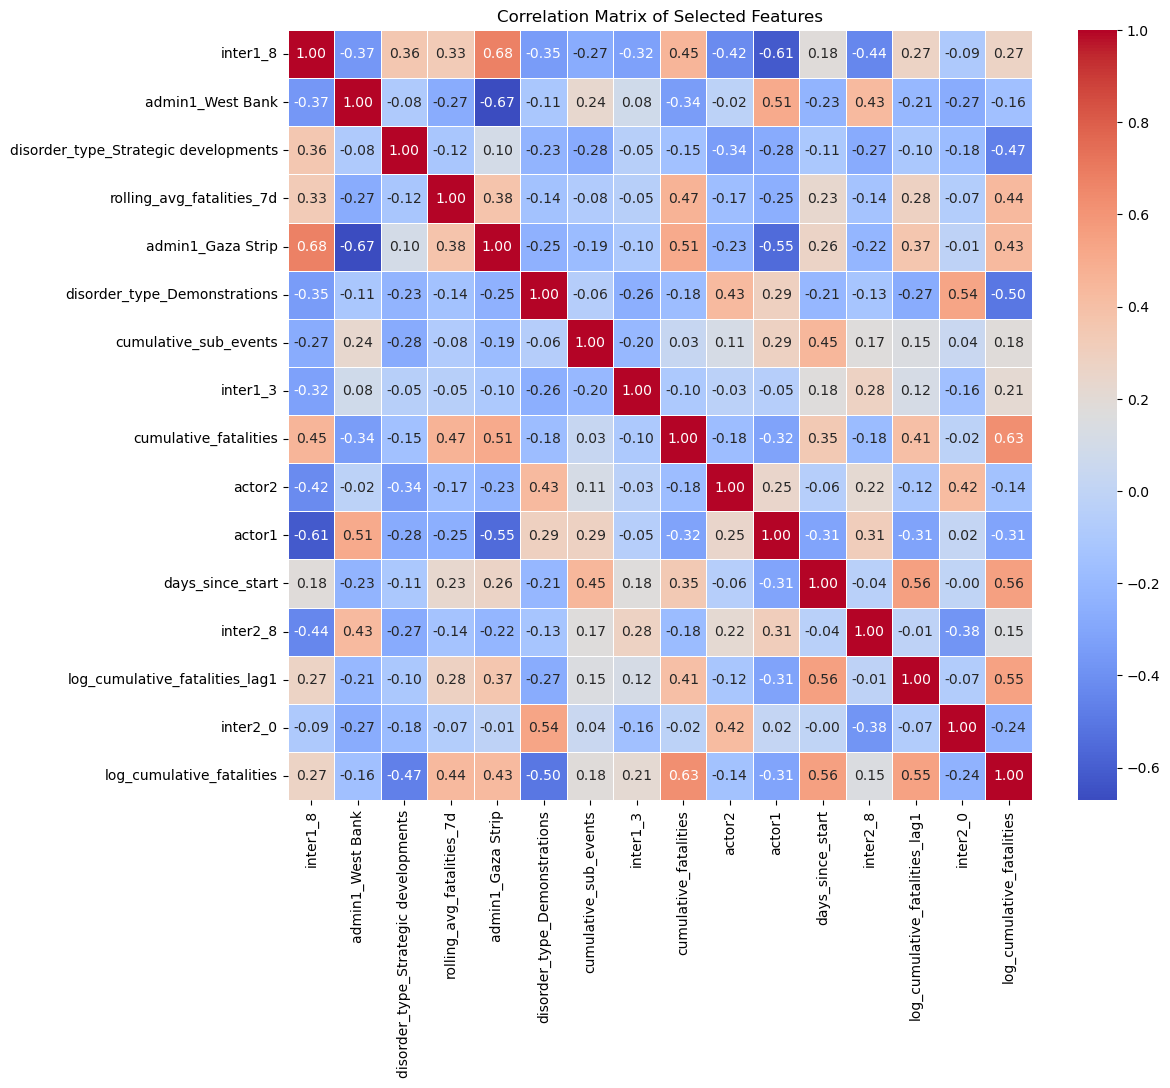

In [33]:
# Class Imbalance
sub_event_type_columns = [col for col in log_data_encoded.columns if col.startswith('sub_event_type_')]
class_counts = log_data_encoded[sub_event_type_columns].sum()
class_percentages = class_counts / len(log_data_encoded) * 100
print("Class Distribution:")
print(class_percentages)

# Multicollinearity
selected_data = log_data_encoded[selected_features]
correlation_matrix = selected_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Selected Features")
plt.show()

The following code shows us that there are a few features with high class imbalances: 5 values above 9%
We also have a few features that have a high correlation such as 'log_days_since_start_lag' 1 2 and 3 all have a correlation of 1.0 indicating the presence of multicollinearity. 

In [34]:
def test_stationarity(timeseries):
    # ADF test
    adf_result = adfuller(timeseries)
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    
    # KPSS test
    kpss_result = kpss(timeseries)
    print(f"KPSS Statistic: {kpss_result[0]}")
    print(f"p-value: {kpss_result[1]}")

for col in selected_features:
    print(f"Stationarity Test for {col}:")
    test_stationarity(log_data_encoded[col])
    print()

Stationarity Test for inter1_8:
ADF Statistic: -12.060141523138203
p-value: 2.4803164690186805e-22
KPSS Statistic: 20.533780495871408
p-value: 0.01

Stationarity Test for admin1_West Bank:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_35277/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -12.784549070852114
p-value: 7.294002601329369e-24
KPSS Statistic: 22.671058679138742
p-value: 0.01

Stationarity Test for disorder_type_Strategic developments:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_35277/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -16.040629327255946
p-value: 5.919405431313334e-29
KPSS Statistic: 15.251725858298274
p-value: 0.01

Stationarity Test for rolling_avg_fatalities_7d:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_35277/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -14.53744548314206
p-value: 5.211250919162529e-27
KPSS Statistic: 13.402199120352824
p-value: 0.01

Stationarity Test for admin1_Gaza Strip:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_35277/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -9.703117671080607
p-value: 1.059160715999903e-16
KPSS Statistic: 23.026164021344872
p-value: 0.01

Stationarity Test for disorder_type_Demonstrations:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_35277/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -13.500576985460892
p-value: 2.9825356893457593e-25
KPSS Statistic: 17.741149528402982
p-value: 0.01

Stationarity Test for cumulative_sub_events:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_35277/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -6.84643147423048
p-value: 1.7380587547088236e-09
KPSS Statistic: 21.093851255713496
p-value: 0.01

Stationarity Test for inter1_3:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_35277/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -14.589945930043617
p-value: 4.330616973357374e-27
KPSS Statistic: 28.39159962699679
p-value: 0.01

Stationarity Test for cumulative_fatalities:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_35277/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -6.529160950413836
p-value: 9.969972209061724e-09
KPSS Statistic: 24.96437504288526
p-value: 0.01

Stationarity Test for actor2:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_35277/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -16.731393601337686
p-value: 1.3821609593477742e-29
KPSS Statistic: 6.1599406817822375
p-value: 0.01

Stationarity Test for actor1:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_35277/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -8.86162822032417
p-value: 1.4775316401192507e-14
KPSS Statistic: 23.90517730009339
p-value: 0.01

Stationarity Test for days_since_start:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_35277/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -12.781355335995366
p-value: 7.403729714320849e-24
KPSS Statistic: 27.3458485907781
p-value: 0.01

Stationarity Test for inter2_8:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_35277/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -21.66416176736641
p-value: 0.0
KPSS Statistic: 4.480722861756568
p-value: 0.01

Stationarity Test for log_cumulative_fatalities_lag1:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_35277/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -5.073244562627054
p-value: 1.5863695603203463e-05
KPSS Statistic: 27.493969920637344
p-value: 0.01

Stationarity Test for inter2_0:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_35277/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -36.609340507498274
p-value: 0.0
KPSS Statistic: 0.8160568961717696
p-value: 0.01

Stationarity Test for log_cumulative_fatalities:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_35277/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -5.074658030079506
p-value: 1.576063548372852e-05
KPSS Statistic: 27.497229505058357
p-value: 0.01



/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_35277/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


P-Values are almost all near 0 indicating that we can reject the null hypothesis of non-stationarity. Suggests that the selected features are likely stationary which is what we want!

In [235]:
def test_heteroscedasticity(y, X):
    X_const = add_constant(X)
    
    # Breusch-Pagan test
    bp_result = het_breuschpagan(y, X_const)
    print(f"Breusch-Pagan Statistic: {bp_result[0]}")
    print(f"p-value: {bp_result[1]}")

In [236]:
#X = log_data_encoded[selected_features]

#for col in sub_event_type_columns:
    #print(f"Heteroscedasticity Test for {col}:")
    #y = log_data_encoded[col]
    #test_heteroscedasticity(y, X)
    #print()

Heteroscedasticity Test for sub_event_type_Abduction/forced disappearance:
Breusch-Pagan Statistic: 258.6853875783514
p-value: 8.529210019909095e-46

Heteroscedasticity Test for sub_event_type_Agreement:
Breusch-Pagan Statistic: 137.46633103267538
p-value: 2.2551601079305368e-21

Heteroscedasticity Test for sub_event_type_Armed clash:
Breusch-Pagan Statistic: 15010.851376037606
p-value: 0.0

Heteroscedasticity Test for sub_event_type_Arrests:
Breusch-Pagan Statistic: 835.1411331438151
p-value: 2.0017501475850143e-167

Heteroscedasticity Test for sub_event_type_Attack:
Breusch-Pagan Statistic: 10980.2763487149
p-value: 0.0

Heteroscedasticity Test for sub_event_type_Change to group/activity:
Breusch-Pagan Statistic: 3048.6039860452483
p-value: 0.0

Heteroscedasticity Test for sub_event_type_Disrupted weapons use:
Breusch-Pagan Statistic: 13742.924493352222
p-value: 0.0

Heteroscedasticity Test for sub_event_type_Government regains territory:
Breusch-Pagan Statistic: 86.8793738655859
p-v

Indication of heteroskedasticity due to p-values < 0.05 + extremely large BP stat! - Non Constant Variance throughout observations

In [237]:
#X = sm.add_constant(log_data_encoded[selected_features])

#for col in sub_event_type_columns:
   # print(f"OLS Regression with Robust Standard Errors for {col}")
   # y = log_data_encoded[col]
   # model = sm.OLS(y, X)
   # results = model.fit(cov_type='HC1')  # 'HC1' for robust standard errors
   # print(results.summary())
   # print("\n")

OLS Regression with Robust Standard Errors for sub_event_type_Abduction/forced disappearance
                                          OLS Regression Results                                         
Dep. Variable:     sub_event_type_Abduction/forced disappearance   R-squared:                       0.009
Model:                                                       OLS   Adj. R-squared:                  0.009
Method:                                            Least Squares   F-statistic:                    0.3814
Date:                                           Thu, 02 May 2024   Prob (F-statistic):              0.987
Time:                                                   15:04:50   Log-Likelihood:                 79511.
No. Observations:                                          28252   AIC:                        -1.590e+05
Df Residuals:                                              28235   BIC:                        -1.588e+05
Df Model:                                                  

In [238]:
#for col in sub_event_type_columns:
  #  print(f"RLM Regression for {col}")
  #  y = log_data_encoded[col]
    
    # Initialize RLM with HuberT norm for robustness
  #  model_rlm = sm.RLM(y, X, M=sm.robust.norms.HuberT())
  #  results_rlm = model_rlm.fit()
    
  #  print(results_rlm.summary())
  #  print("\n")

RLM Regression for sub_event_type_Abduction/forced disappearance
                                  Robust linear Model Regression Results                                 
Dep. Variable:     sub_event_type_Abduction/forced disappearance   No. Observations:                28252
Model:                                                       RLM   Df Residuals:                    28235
Method:                                                     IRLS   Df Model:                           16
Norm:                                                     HuberT                                         
Scale Est.:                                                  mad                                         
Cov Type:                                                     H1                                         
Date:                                           Thu, 02 May 2024                                         
Time:                                                   15:04:53                       

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/statsmodels/robust/norms.py:215: RuntimeWarning: overflow encountered in square
  return (test * 0.5 * z**2 +
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/statsmodels/robust/norms.py:215: RuntimeWarning: invalid value encountered in multiply
  return (test * 0.5 * z**2 +


                                 Robust linear Model Regression Results                                
Dep. Variable:     sub_event_type_Government regains territory   No. Observations:                28252
Model:                                                     RLM   Df Residuals:                    28235
Method:                                                   IRLS   Df Model:                           16
Norm:                                                   HuberT                                         
Scale Est.:                                                mad                                         
Cov Type:                                                   H1                                         
Date:                                         Thu, 02 May 2024                                         
Time:                                                 15:04:59                                         
No. Iterations:                                             50  

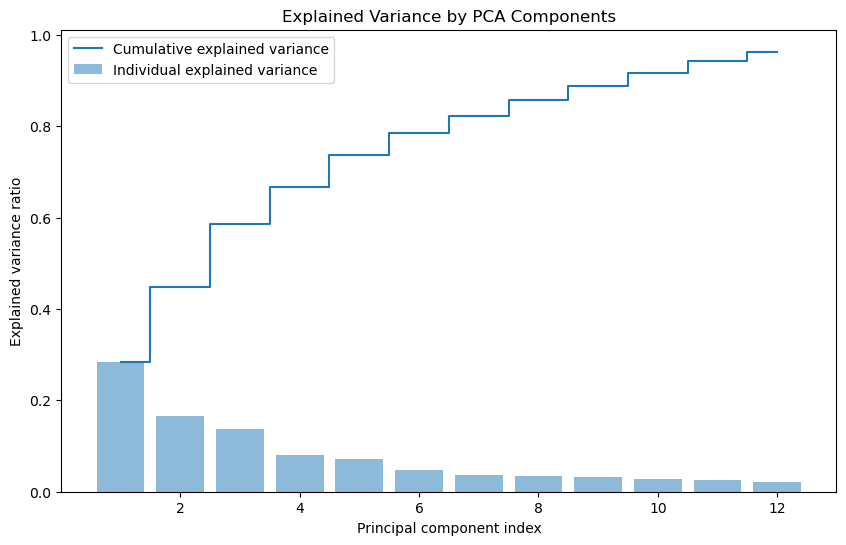

In [35]:
# standardizing
scaler = StandardScaler()
features_scaled = scaler.fit_transform(log_data_encoded[selected_features])

# attempt to fix Multicollinearity with PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(features_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('Explained Variance by PCA Components')
plt.legend(loc='best')
plt.show()

In [36]:
#Selected Features
X_selected = log_data_encoded[selected_features].copy()
y = log_data_encoded[sub_event_type_columns].values

X_train, X_test, y_train, y_test , train_idx, test_idx = train_test_split(X_pca, y, log_data_encoded.index ,
                                                                          test_size=0.2, random_state=42, shuffle=False)

y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

#y_train_encoded = tf.keras.utils.to_categorical(y_train)
#y_test_encoded = tf.keras.utils.to_categorical(y_test)

In [37]:
#X_train = X_train.astype({col: 'int64' for col in X_train.columns if X_train[col].dtype == 'bool'})
#X_test = X_test.astype({col: 'int64' for col in X_test.columns if X_test[col].dtype == 'bool'})
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print("Labels for Y")
print(y_train_labels.shape)
print(y_test_labels.shape)
print(y_train_labels.dtype)
print(y_test_labels.dtype)
print(train_idx.shape)
print(test_idx.shape)
#print(X_train.dtypes)

(22601, 12)
(5651, 12)
(22601, 17)
(5651, 17)
Labels for Y
(22601,)
(5651,)
int64
int64
(22601,)
(5651,)


In [38]:
#print(X_selected_train.head())
#print(y_train.head())
#print(y_train_encoded)

In [39]:
#Decision Tree Baseline

tree_classifier = DecisionTreeClassifier(random_state=42)

tree_classifier.fit(X_train, y_train)

tree_predictions = tree_classifier.predict(X_test)

tree_accuracy = accuracy_score(y_test, tree_predictions)
tree_classification_report = classification_report(y_test, tree_predictions)
print(f"Accuracy of Decision Tree: {tree_accuracy:.2f}")
print(tree_classification_report)

Accuracy of Decision Tree: 0.87
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.00      0.00      0.00         0
           2       0.76      0.96      0.85       832
           3       0.48      0.82      0.61        17
           4       0.69      0.91      0.78       363
           5       0.50      0.17      0.25         6
           6       0.91      0.81      0.85       149
           7       0.00      0.00      0.00         0
           8       0.87      0.80      0.83        59
           9       0.83      0.81      0.82       280
          10       0.97      0.99      0.98       783
          11       0.00      0.00      0.00         0
          12       0.38      0.48      0.43        64
          13       0.67      0.54      0.60        48
          14       0.69      0.37      0.48        60
          15       0.97      0.62      0.76      1123
          16       0.58      0.59      0.58      

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

In [40]:
# Logistic Regression
logistic_regressor = LogisticRegression(max_iter=1000, random_state=42)
logistic_regressor.fit(X_train, y_train_labels)

logistic_predictions = logistic_regressor.predict(X_test)
logistic_accuracy = accuracy_score(y_test_labels, logistic_predictions)
logistic_classification_report = classification_report(y_test_labels, logistic_predictions)

print(f"Accuracy of Logistic Regression Baseline: {logistic_accuracy:.2f}")
print(logistic_classification_report)

Accuracy of Logistic Regression Baseline: 0.90
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1811
           2       0.81      0.99      0.89       832
           3       1.00      0.29      0.45        17
           4       0.82      0.83      0.82       363
           5       1.00      0.67      0.80         6
           6       0.93      1.00      0.96       149
           8       0.93      0.86      0.89        59
           9       0.85      0.56      0.67       280
          10       1.00      1.00      1.00       783
          12       0.24      0.61      0.34        64
          13       1.00      1.00      1.00        48
          14       1.00      0.07      0.12        60
          15       0.90      0.78      0.84      1123
          16       0.96      0.96      0.96        56

    accuracy                           0.90      5651
   macro avg       0.89      0.76      0.77      5651
weighted avg       0.92      0.90

In [41]:
#Selected Features FOR LSTM input
def create_sequences(data, n_steps):
    X = []
    for i in range(len(data) - n_steps + 1):
        X.append(data[i:i + n_steps])
    return np.array(X)

n_steps = 24 # Number of timesteps
n_features = X_train.shape[1] # Number of features per step

#Reshaping data
X_train_reshaped = create_sequences(X_train, n_steps)
X_test_reshaped = create_sequences(X_test, n_steps)

#matching labels to new data
y_train_reshaped = y_train_labels[n_steps-1:]
y_test_reshaped = y_test_labels[n_steps-1:]

In [42]:
#Grid Search for Hyperparameters - LSTM
def create_model(n_steps, n_features, n_nodes, dropout_rate, n_classes):
    model = Sequential([
        LSTM(n_nodes, input_shape=(n_steps, n_features), return_sequences=True),
        Dropout(dropout_rate),
        LSTM(n_nodes),
        Dropout(dropout_rate),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'], run_eagerly = True)
    return model

# [time steps, # of features per time step, neurons, dropout rate, output class]
configs = [
    [24, X_train_reshaped.shape[2], 50, 0.1, len(np.unique(y_train_reshaped))], #Testing 10% dropout and 50 neurons, 24 time steps
    [24, X_train_reshaped.shape[2], 50, 0.2, len(np.unique(y_train_reshaped))], #Testing 20% dropout and 50 neurons, 24 time steps
    [24, X_train_reshaped.shape[2], 100, 0.2, len(np.unique(y_train_reshaped))], #testing 20% dropout and 100 neurons, 24 time steps
    [24, X_train_reshaped.shape[2], 100, 0.3, len(np.unique(y_train_reshaped))], #testing 30% dropout and 100 neurons, 24 time steps
]

# run model with configs
def run_model(config):
    n_steps, n_features, n_nodes, dropout_rate, n_classes = config
    model = create_model(n_steps, n_features, n_nodes, dropout_rate, n_classes)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train_reshaped, y_train_reshaped, epochs=50, batch_size=64, validation_split=0.1, verbose=1, 
                        callbacks=[early_stopping])
    _, accuracy = model.evaluate(X_test_reshaped, y_test_reshaped, verbose=0)
    return accuracy

#running the grid search
best_accuracy = 0
best_config = None
for config in configs:
    accuracy = run_model(config)
    print(f'Config: {config}, Accuracy: {accuracy:.3f}')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_config = config

print(f'Best Config: {best_config}, Best Accuracy: {best_accuracy:.3f}')

2024-05-04 00:51:15.558537: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-04 00:51:15.558591: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-04 00:51:15.558600: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-04 00:51:15.559144: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-04 00:51:15.559390: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50
318/318 [==============================] - 12s 35ms/step - loss: 1.3410 - accuracy: 0.5919 - val_loss: 0.9536 - val_accuracy: 0.6922
Epoch 2/50
318/318 [==============================] - 11s 36ms/step - loss: 0.4431 - accuracy: 0.8793 - val_loss: 0.5801 - val_accuracy: 0.8153
Epoch 3/50
318/318 [==============================] - 11s 34ms/step - loss: 0.2915 - accuracy: 0.9141 - val_loss: 0.4493 - val_accuracy: 0.8649
Epoch 4/50
318/318 [==============================] - 11s 36ms/step - loss: 0.2279 - accuracy: 0.9358 - val_loss: 0.4084 - val_accuracy: 0.8764
Epoch 5/50
318/318 [==============================] - 11s 34ms/step - loss: 0.1865 - accuracy: 0.9468 - val_loss: 0.3704 - val_accuracy: 0.8778
Epoch 6/50
318/318 [==============================] - 11s 35ms/step - loss: 0.1635 - accuracy: 0.9535 - val_loss: 0.3581 - val_accuracy: 0.8809
Epoch 7/50
318/318 [==============================] - 11s 35ms/step - loss: 0.1451 - accuracy: 0.9570 - val_loss: 0.3136 - val_accuracy:

In [43]:
# Retraining Actual Model
def create_model(n_steps, n_features, n_nodes, dropout_rate, n_classes):
    model = Sequential()
    model.add(LSTM(n_nodes, input_shape=(n_steps, n_features), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(n_nodes))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)
    return model

# best parameters
best_params = best_config

# model using the best parameters
LSTM_model_best = create_model(*best_params)

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = LSTM_model_best.fit(X_train_reshaped, y_train_reshaped, epochs=50, batch_size=64,
                              validation_split=0.1, verbose=1, callbacks=[early_stopping])

Epoch 1/50
318/318 [==============================] - 13s 39ms/step - loss: 1.0576 - accuracy: 0.6786 - val_loss: 0.6386 - val_accuracy: 0.8202
Epoch 2/50
318/318 [==============================] - 12s 39ms/step - loss: 0.3214 - accuracy: 0.9036 - val_loss: 0.4498 - val_accuracy: 0.8592
Epoch 3/50
318/318 [==============================] - 13s 40ms/step - loss: 0.2353 - accuracy: 0.9310 - val_loss: 0.3771 - val_accuracy: 0.8893
Epoch 4/50
318/318 [==============================] - 13s 41ms/step - loss: 0.1890 - accuracy: 0.9444 - val_loss: 0.3768 - val_accuracy: 0.8826
Epoch 5/50
318/318 [==============================] - 14s 43ms/step - loss: 0.1640 - accuracy: 0.9518 - val_loss: 0.3075 - val_accuracy: 0.8973
Epoch 6/50
318/318 [==============================] - 13s 40ms/step - loss: 0.1448 - accuracy: 0.9569 - val_loss: 0.2924 - val_accuracy: 0.9017
Epoch 7/50
318/318 [==============================] - 12s 38ms/step - loss: 0.1306 - accuracy: 0.9585 - val_loss: 0.3205 - val_accuracy:

In [44]:
# Evaluation
_, accuracy = LSTM_model_best.evaluate(X_test_reshaped, y_test_reshaped, verbose=0)
print(f'Test Accuracy LSTM: {accuracy:.3f}')

# Predictions
y_pred_LSTM = LSTM_model_best.predict(X_test_reshaped)
y_pred_classes_LSTM = np.argmax(y_pred_LSTM, axis=1) # converting probabilities to class labels

# Actual classes
actual_classes_LSTM = y_test_reshaped  

# Metrics
mae_LSTM = mean_absolute_error(actual_classes_LSTM, y_pred_classes_LSTM)
print(f'Mean Absolute Error LSTM: {mae_LSTM:.2f}')

mse_LSTM = mean_squared_error(actual_classes_LSTM, y_pred_classes_LSTM)
print(f'Mean Squared Error LSTM: {mse_LSTM:.2f}')

rmse_LSTM = np.sqrt(mse_LSTM)
print(f'Root Mean Squared Error LSTM: {rmse_LSTM:.2f}')

Test Accuracy LSTM: 0.853
176/176 [==============================] - 2s 9ms/step
Mean Absolute Error LSTM: 1.46
Mean Squared Error LSTM: 17.93
Root Mean Squared Error LSTM: 4.23


In [45]:
sub_event_type_labels = [col.split('_')[-1] for col in sub_event_type_columns]

predicted_labels_LSTM = [sub_event_type_labels[i] for i in y_pred_classes_LSTM]
actual_labels_LSTM = [sub_event_type_labels[i] for i in actual_classes_LSTM]

for actual, predicted in zip(actual_labels_LSTM[:10], predicted_labels_LSTM[:10]):
    print(f"Actual: {actual}, Predicted: {predicted}")

Actual: Looting/property destruction, Predicted: Looting/property destruction
Actual: Disrupted weapons use, Predicted: Disrupted weapons use
Actual: Shelling/artillery/missile attack, Predicted: Armed clash
Actual: Grenade, Predicted: Grenade
Actual: Armed clash, Predicted: Armed clash
Actual: Mob violence, Predicted: Mob violence
Actual: Mob violence, Predicted: Mob violence
Actual: Mob violence, Predicted: Mob violence
Actual: Armed clash, Predicted: Armed clash
Actual: Armed clash, Predicted: Armed clash


In [46]:
# Showing errors
errors_LSTM = np.where(y_pred_classes_LSTM != actual_classes_LSTM)[0]
print(f'Number of errors LSTM: {len(errors_LSTM)} / {len(actual_classes_LSTM)}')
for i in errors_LSTM[:10]:  # first 10
    print(f'Index: {i}, Predicted: {predicted_labels_LSTM[i]}, Actual: {actual_labels_LSTM[i]}')

Number of errors LSTM: 826 / 5628
Index: 2, Predicted: Armed clash, Actual: Shelling/artillery/missile attack
Index: 17, Predicted: Armed clash, Actual: Shelling/artillery/missile attack
Index: 18, Predicted: Armed clash, Actual: Shelling/artillery/missile attack
Index: 19, Predicted: Armed clash, Actual: Shelling/artillery/missile attack
Index: 20, Predicted: Armed clash, Actual: Shelling/artillery/missile attack
Index: 39, Predicted: Armed clash, Actual: Shelling/artillery/missile attack
Index: 40, Predicted: Armed clash, Actual: Shelling/artillery/missile attack
Index: 57, Predicted: Armed clash, Actual: Shelling/artillery/missile attack
Index: 70, Predicted: Shelling/artillery/missile attack, Actual: Attack
Index: 86, Predicted: Disrupted weapons use, Actual: Other


              precision    recall  f1-score      support
0              0.907855  0.997786  0.950699  1807.000000
2              0.789883  0.983051  0.875944   826.000000
3              1.000000  0.235294  0.380952    17.000000
4              0.708333  0.796143  0.749676   363.000000
5              0.500000  0.833333  0.625000     6.000000
6              0.789189  0.979866  0.874251   149.000000
8              0.892857  0.847458  0.869565    59.000000
9              0.857955  0.541219  0.663736   279.000000
10             1.000000  1.000000  1.000000   778.000000
12             0.200000  0.435484  0.274112    62.000000
13             0.979592  1.000000  0.989691    48.000000
14             1.000000  0.100000  0.181818    60.000000
15             0.838624  0.567084  0.676628  1118.000000
16             0.960784  0.875000  0.915888    56.000000
accuracy       0.853234  0.853234  0.853234     0.853234
macro avg      0.816077  0.727980  0.716283  5628.000000
weighted avg   0.865051  0.8532

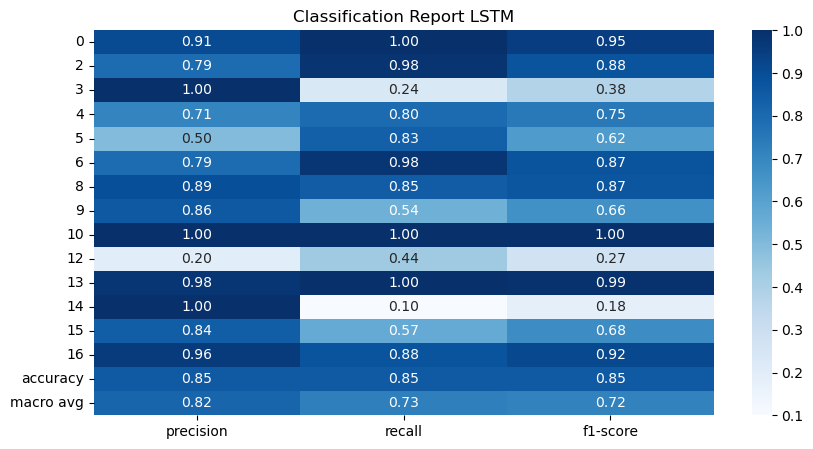

In [47]:
# Classification report
report_LSTM = classification_report(actual_classes_LSTM, y_pred_classes_LSTM, output_dict=True)
report_LSTM_df = pd.DataFrame(report_LSTM).transpose()
print(report_LSTM_df)

plt.figure(figsize=(10, 5))
sns.heatmap(report_LSTM_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues")
plt.title('Classification Report LSTM')
plt.show()

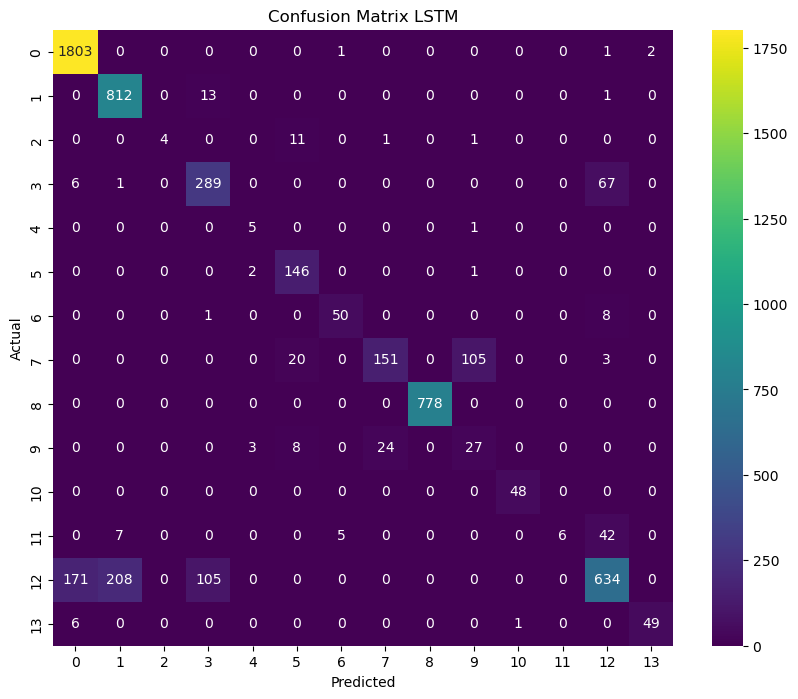

In [48]:
# Confusion Matrix
conf_matrix_LSTM = confusion_matrix(actual_classes_LSTM, y_pred_classes_LSTM)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_LSTM, annot=True, fmt='d', cmap='viridis')  # 'd' for integer format
plt.title('Confusion Matrix LSTM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

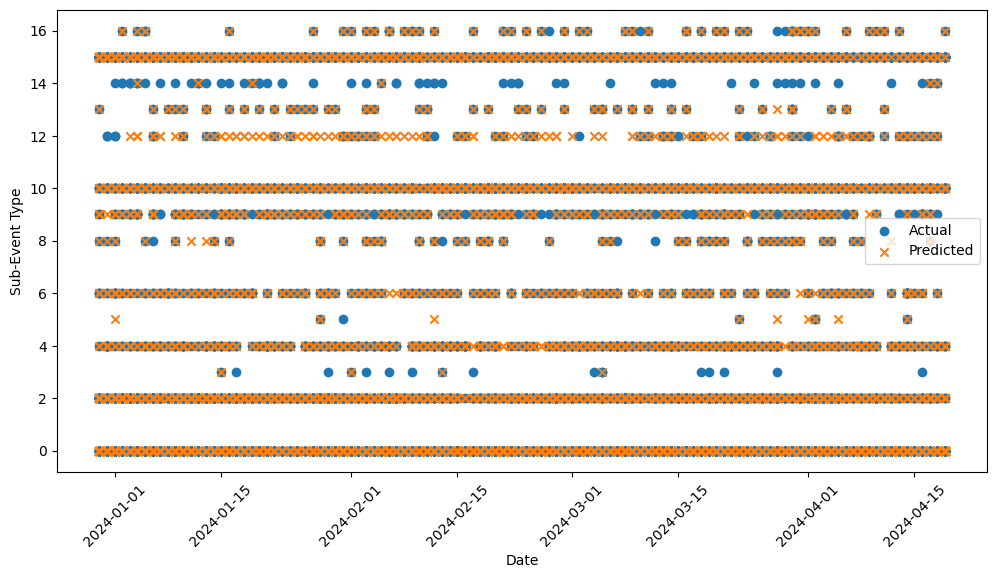

In [49]:
# event_dates for test set
event_dates_test = log_data_encoded.loc[test_idx, 'event_date'].reset_index(drop=True)

# match length of event_dates_test to actual_classes_LSTM and y_pred_classes_LSTM
event_dates_test = event_dates_test[-len(actual_classes_LSTM):]

all_labels = np.unique(y_train_labels)

# df with event_date, actual labels, and predicted labels
results_LSTM_df = pd.DataFrame({
    'event_date': event_dates_test,
    'actual_labels': [all_labels[i] for i in actual_classes_LSTM],
    'predicted_labels': [all_labels[i] for i in y_pred_classes_LSTM]
})

# converting datetime
results_LSTM_df['event_date'] = pd.to_datetime(results_LSTM_df['event_date'])

# Set event_date as the index
results_LSTM_df.set_index('event_date', inplace=True)

# Plot actual vs. predicted against time
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(results_LSTM_df.index, results_LSTM_df['actual_labels'], label='Actual', marker='o')
ax.scatter(results_LSTM_df.index, results_LSTM_df['predicted_labels'], label='Predicted', marker='x')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sub-Event Type')
plt.xticks(rotation=45)
plt.show()

When circles and crosses are at the same level on the plot for a given date, it means the prediction was correct. The values that differ on the y-axis indicate a misprediction.

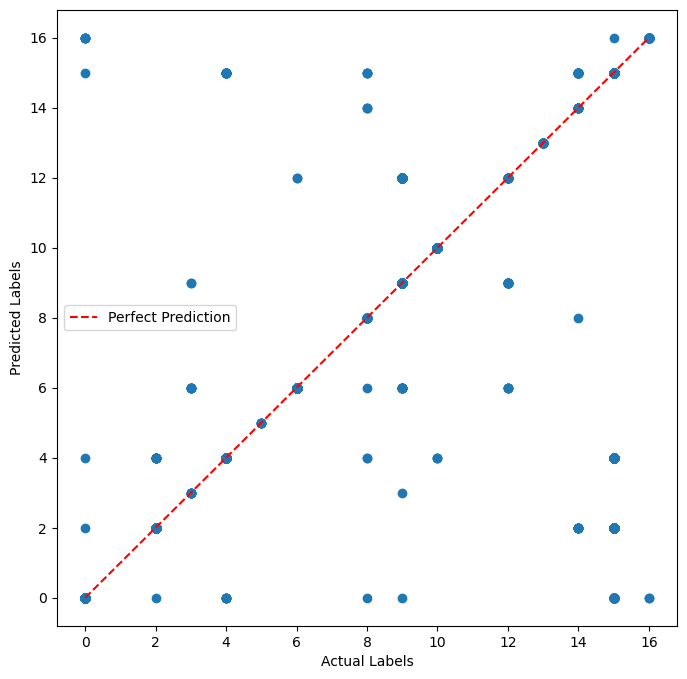

In [266]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(results_LSTM_df['actual_labels'], results_LSTM_df['predicted_labels'])
ax.plot([min(results_LSTM_df['actual_labels']), max(results_LSTM_df['actual_labels'])], [min(results_LSTM_df['actual_labels']), max(results_LSTM_df['actual_labels'])], 'r--', label='Perfect Prediction')
ax.set_xlabel('Actual Labels')
ax.set_ylabel('Predicted Labels')
ax.legend()
plt.show()

Future data exploration shows overfitting

In [50]:
# Create a new DataFrame with future dates for the next 6 months
#last_date = results_LSTM_df.index[-1]
#future_dates = pd.date_range(start=last_date, periods=6, freq='M')
#future_df = pd.DataFrame(index=future_dates, columns=['predicted_labels'])

# Predict labels for the future dates using the trained model
#future_X = future_X.reshape(future_X.shape[0], best_params[0], future_X.shape[2])
#future_labels = LSTM_embed_model_best.predict(future_X)
#future_labels_classes = np.argmax(future_labels, axis=1)
#future_df['predicted_labels'] = [all_labels[i] for i in future_labels_classes]

# Append the forecasted labels to the existing results_LSTM_df
#results_LSTM_df_forecast = pd.concat([results_LSTM_df, future_df])

# Plot the actual labels, predicted labels, and forecasted labels
#fig, ax = plt.subplots(figsize=(12, 6))
#ax.plot(results_LSTM_df.index, results_LSTM_df['actual_labels'], label='Actual')
#ax.plot(results_LSTM_df.index, results_LSTM_df['predicted_labels'], label='Predicted')
#ax.plot(future_df.index, future_df['predicted_labels'], label='Forecast', linestyle='--')
#ax.legend()
#ax.set_xlabel('Date')
#ax.set_ylabel('Sub-Event Type')
#plt.xticks(rotation=45)
#plt.show()

In [51]:
X_train_reshaped.shape

(22578, 24, 12)

In [52]:
# Testing 10% dropout and 50 neurons, 7 time steps - 0.843
# Testing 20% dropout and 50 neurons, 14 time steps - 0.829
# Testing 20% dropout and 100 neurons, 14 time steps - 0.827
# Testing 20% dropout and 50 neurons, 24 time steps - 0.814
# Testing 30% dropout and 100 neurons, 24 time steps - 0.879

In [53]:
#Grid Search for Hyperparamers - LSTM With Embedding
def create_model(n_steps, n_features, n_nodes, dropout_rate, n_classes):
    model = Sequential([
        Input(shape=(n_steps, n_features)),
        LSTM(n_nodes, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(n_nodes),
        Dropout(dropout_rate),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# [time steps, # of features per time step, neurons, dropout rate, output class]
configs = [
    [7, X_train_reshaped.shape[2], 75, 0.2, 20],  
    [7, X_train_reshaped.shape[2], 50, 0.3, 20],  
    [7, X_train_reshaped.shape[2], 100, 0.4, 20],  
    [24, X_train_reshaped.shape[2], 75, 0.2, 20],
    [24, X_train_reshaped.shape[2], 50, 0.3, 20],  
    [24, X_train_reshaped.shape[2], 100, 0.4, 20]
]

# run model with a specific config
def run_model(config):
    n_steps, n_features, n_nodes, dropout_rate, n_classes = config

    #Reshaping data
    X_train_reshaped = create_sequences(X_train, n_steps)
    X_test_reshaped = create_sequences(X_test, n_steps)
    
    #matching labels to new data
    y_train_reshaped = y_train_labels[n_steps-1:]
    y_test_reshaped = y_test_labels[n_steps-1:]

    n_steps, n_features, n_nodes, dropout_rate, n_classes = config
    model = create_model(n_steps, n_features, n_nodes, dropout_rate, n_classes)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train_reshaped, y_train_reshaped, epochs=50, batch_size=64, validation_split=0.1, verbose=1, callbacks=[early_stopping])
    _, accuracy = model.evaluate(X_test_reshaped, y_test_reshaped, verbose=0)
    return accuracy

# grid search
best_accuracy = 0
best_config = None
for config in configs:
    accuracy = run_model(config)
    print(f'Config: {config}, Accuracy: {accuracy:.3f}')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_config = config

print(f'Best Config: {best_config}, Best Accuracy: {best_accuracy:.3f}')

Epoch 1/50


2024-05-04 01:18:27.640384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:18:27.842004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:18:27.916334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:18:28.030509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  4/318 [..............................] - ETA: 5s - loss: 3.0012 - accuracy: 0.0977   

2024-05-04 01:18:28.149698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - ETA: 0s - loss: 1.1193 - accuracy: 0.6711

2024-05-04 01:18:33.258284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:18:33.336735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:18:33.395003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 7s 17ms/step - loss: 1.1193 - accuracy: 0.6711 - val_loss: 0.6588 - val_accuracy: 0.7819
Epoch 2/50
318/318 [==============================] - 5s 14ms/step - loss: 0.3019 - accuracy: 0.9132 - val_loss: 0.4670 - val_accuracy: 0.8425
Epoch 3/50
318/318 [==============================] - 5s 15ms/step - loss: 0.2171 - accuracy: 0.9381 - val_loss: 0.3752 - val_accuracy: 0.8832
Epoch 4/50
318/318 [==============================] - 5s 14ms/step - loss: 0.1802 - accuracy: 0.9482 - val_loss: 0.3509 - val_accuracy: 0.8827
Epoch 5/50
318/318 [==============================] - 4s 14ms/step - loss: 0.1591 - accuracy: 0.9530 - val_loss: 0.3146 - val_accuracy: 0.8934
Epoch 6/50
318/318 [==============================] - 4s 14ms/step - loss: 0.1419 - accuracy: 0.9555 - val_loss: 0.2919 - val_accuracy: 0.8969
Epoch 7/50
318/318 [==============================] - 4s 14ms/step - loss: 0.1261 - accuracy: 0.9608 - val_loss: 0.2785 - val_accuracy: 0.9027
Epoch 8/50

2024-05-04 01:20:20.156716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:20:20.323826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:20:20.395020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:20:20.513703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  3/318 [..............................] - ETA: 7s - loss: 3.0005 - accuracy: 0.0417  

2024-05-04 01:20:20.631868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - ETA: 0s - loss: 1.4778 - accuracy: 0.5656

2024-05-04 01:20:25.477148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:20:25.547191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:20:25.597679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 7s 16ms/step - loss: 1.4778 - accuracy: 0.5656 - val_loss: 1.0654 - val_accuracy: 0.6358
Epoch 2/50
318/318 [==============================] - 5s 15ms/step - loss: 0.4857 - accuracy: 0.8657 - val_loss: 0.5800 - val_accuracy: 0.8442
Epoch 3/50
318/318 [==============================] - 5s 14ms/step - loss: 0.3338 - accuracy: 0.9062 - val_loss: 0.4926 - val_accuracy: 0.8540
Epoch 4/50
318/318 [==============================] - 5s 15ms/step - loss: 0.2731 - accuracy: 0.9234 - val_loss: 0.4404 - val_accuracy: 0.8699
Epoch 5/50
318/318 [==============================] - 4s 14ms/step - loss: 0.2314 - accuracy: 0.9364 - val_loss: 0.4110 - val_accuracy: 0.8717
Epoch 6/50
318/318 [==============================] - 5s 14ms/step - loss: 0.2033 - accuracy: 0.9433 - val_loss: 0.3803 - val_accuracy: 0.8765
Epoch 7/50
318/318 [==============================] - 5s 16ms/step - loss: 0.1857 - accuracy: 0.9463 - val_loss: 0.3546 - val_accuracy: 0.8836
Epoch 8/50

2024-05-04 01:23:11.165103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:23:11.363320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:23:11.426602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:23:11.540231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  4/318 [..............................] - ETA: 6s - loss: 2.9625 - accuracy: 0.1445  

2024-05-04 01:23:11.653282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - ETA: 0s - loss: 1.1012 - accuracy: 0.6714

2024-05-04 01:23:16.276523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:23:16.342966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:23:16.391382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 7s 16ms/step - loss: 1.1012 - accuracy: 0.6714 - val_loss: 0.6864 - val_accuracy: 0.7867
Epoch 2/50
318/318 [==============================] - 4s 14ms/step - loss: 0.3268 - accuracy: 0.8995 - val_loss: 0.4459 - val_accuracy: 0.8584
Epoch 3/50
318/318 [==============================] - 4s 14ms/step - loss: 0.2433 - accuracy: 0.9251 - val_loss: 0.3844 - val_accuracy: 0.8761
Epoch 4/50
318/318 [==============================] - 4s 14ms/step - loss: 0.2046 - accuracy: 0.9404 - val_loss: 0.3601 - val_accuracy: 0.8810
Epoch 5/50
318/318 [==============================] - 4s 14ms/step - loss: 0.1777 - accuracy: 0.9473 - val_loss: 0.3347 - val_accuracy: 0.8889
Epoch 6/50
318/318 [==============================] - 4s 14ms/step - loss: 0.1615 - accuracy: 0.9513 - val_loss: 0.3375 - val_accuracy: 0.8863
Epoch 7/50
318/318 [==============================] - 4s 14ms/step - loss: 0.1436 - accuracy: 0.9559 - val_loss: 0.3300 - val_accuracy: 0.8832
Epoch 8/50

2024-05-04 01:25:37.710395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:25:37.876508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:25:37.949476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:25:38.064395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  3/318 [..............................] - ETA: 8s - loss: 3.0072 - accuracy: 0.0885  

2024-05-04 01:25:38.179260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - ETA: 0s - loss: 1.1545 - accuracy: 0.6575

2024-05-04 01:25:43.227772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:25:43.293058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:25:43.344982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 7s 17ms/step - loss: 1.1545 - accuracy: 0.6575 - val_loss: 0.6617 - val_accuracy: 0.7941
Epoch 2/50
318/318 [==============================] - 5s 16ms/step - loss: 0.3436 - accuracy: 0.8969 - val_loss: 0.4754 - val_accuracy: 0.8574
Epoch 3/50
318/318 [==============================] - 5s 16ms/step - loss: 0.2462 - accuracy: 0.9281 - val_loss: 0.3824 - val_accuracy: 0.8800
Epoch 4/50
318/318 [==============================] - 5s 15ms/step - loss: 0.2002 - accuracy: 0.9424 - val_loss: 0.3531 - val_accuracy: 0.8857
Epoch 5/50
318/318 [==============================] - 5s 15ms/step - loss: 0.1721 - accuracy: 0.9498 - val_loss: 0.3594 - val_accuracy: 0.8871
Epoch 6/50
318/318 [==============================] - 5s 16ms/step - loss: 0.1538 - accuracy: 0.9542 - val_loss: 0.3485 - val_accuracy: 0.8893
Epoch 7/50
318/318 [==============================] - 5s 16ms/step - loss: 0.1368 - accuracy: 0.9594 - val_loss: 0.2855 - val_accuracy: 0.9043
Epoch 8/50

2024-05-04 01:28:53.005494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:28:53.221502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:28:53.327945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:28:53.483494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:28:53.645301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - ETA: 0s - loss: 1.4940 - accuracy: 0.5329

2024-05-04 01:29:00.631306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:29:00.710820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:29:00.855547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 9s 24ms/step - loss: 1.4940 - accuracy: 0.5329 - val_loss: 1.0258 - val_accuracy: 0.6572
Epoch 2/50
318/318 [==============================] - 6s 18ms/step - loss: 0.5460 - accuracy: 0.8502 - val_loss: 0.6063 - val_accuracy: 0.8335
Epoch 3/50
318/318 [==============================] - 6s 18ms/step - loss: 0.3646 - accuracy: 0.8974 - val_loss: 0.5073 - val_accuracy: 0.8530
Epoch 4/50
318/318 [==============================] - 5s 17ms/step - loss: 0.2956 - accuracy: 0.9159 - val_loss: 0.4364 - val_accuracy: 0.8574
Epoch 5/50
318/318 [==============================] - 5s 15ms/step - loss: 0.2518 - accuracy: 0.9272 - val_loss: 0.4462 - val_accuracy: 0.8640
Epoch 6/50
318/318 [==============================] - 5s 15ms/step - loss: 0.2245 - accuracy: 0.9359 - val_loss: 0.3810 - val_accuracy: 0.8716
Epoch 7/50
318/318 [==============================] - 5s 15ms/step - loss: 0.2020 - accuracy: 0.9429 - val_loss: 0.3994 - val_accuracy: 0.8751
Epoch 8/50

2024-05-04 01:32:41.407625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:32:41.581123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:32:41.670068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:32:41.813022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/318 [..............................] - ETA: 11:01 - loss: 3.0295 - accuracy: 0.0312

2024-05-04 01:32:41.944675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - ETA: 0s - loss: 1.1479 - accuracy: 0.6532

2024-05-04 01:32:47.602831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:32:47.674342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:32:47.738699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 8s 19ms/step - loss: 1.1479 - accuracy: 0.6532 - val_loss: 0.6654 - val_accuracy: 0.8184
Epoch 2/50
318/318 [==============================] - 7s 21ms/step - loss: 0.3475 - accuracy: 0.8959 - val_loss: 0.4458 - val_accuracy: 0.8614
Epoch 3/50
318/318 [==============================] - 5s 16ms/step - loss: 0.2563 - accuracy: 0.9234 - val_loss: 0.3982 - val_accuracy: 0.8782
Epoch 4/50
318/318 [==============================] - 5s 17ms/step - loss: 0.2117 - accuracy: 0.9389 - val_loss: 0.3420 - val_accuracy: 0.8915
Epoch 5/50
318/318 [==============================] - 5s 17ms/step - loss: 0.1829 - accuracy: 0.9464 - val_loss: 0.3414 - val_accuracy: 0.8937
Epoch 6/50
318/318 [==============================] - 5s 16ms/step - loss: 0.1652 - accuracy: 0.9514 - val_loss: 0.3625 - val_accuracy: 0.8884
Epoch 7/50
318/318 [==============================] - 5s 16ms/step - loss: 0.1518 - accuracy: 0.9541 - val_loss: 0.2965 - val_accuracy: 0.8990
Epoch 8/50

In [54]:
# Retraining LSTM WITH EMBED
def create_model(n_steps, n_features, n_nodes, dropout_rate, n_classes):
    model = Sequential([
        Input(shape=(n_steps, n_features)),
        LSTM(n_nodes, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(n_nodes),
        Dropout(dropout_rate),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# best parameters
best_params = best_config

n_steps = best_params[0]
X_train_reshaped = create_sequences(X_train, n_steps)
X_test_reshaped = create_sequences(X_test, n_steps)
y_train_reshaped = y_train_labels[n_steps-1:]
y_test_reshaped = y_test_labels[n_steps-1:]

LSTM_embed_model_best = create_model(*best_params)

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# train the model
history = LSTM_embed_model_best.fit(X_train_reshaped, y_train_reshaped, epochs=50, batch_size=64, validation_split=0.1, 
                                    verbose=1, callbacks=[early_stopping])

Epoch 1/50


2024-05-04 01:35:16.771917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:35:17.219524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:35:17.398624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:35:17.713163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:35:17.903327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - ETA: 0s - loss: 1.1583 - accuracy: 0.6456

2024-05-04 01:35:24.334131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:35:24.413209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:35:24.498975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 9s 22ms/step - loss: 1.1583 - accuracy: 0.6456 - val_loss: 0.7330 - val_accuracy: 0.7626
Epoch 2/50
318/318 [==============================] - 6s 19ms/step - loss: 0.3605 - accuracy: 0.8951 - val_loss: 0.4967 - val_accuracy: 0.8472
Epoch 3/50
318/318 [==============================] - 6s 20ms/step - loss: 0.2601 - accuracy: 0.9249 - val_loss: 0.4643 - val_accuracy: 0.8543
Epoch 4/50
318/318 [==============================] - 6s 17ms/step - loss: 0.2138 - accuracy: 0.9377 - val_loss: 0.4099 - val_accuracy: 0.8791
Epoch 5/50
318/318 [==============================] - 5s 17ms/step - loss: 0.1871 - accuracy: 0.9453 - val_loss: 0.3646 - val_accuracy: 0.8826
Epoch 6/50
318/318 [==============================] - 5s 17ms/step - loss: 0.1677 - accuracy: 0.9504 - val_loss: 0.3523 - val_accuracy: 0.8866
Epoch 7/50
318/318 [==============================] - 5s 17ms/step - loss: 0.1527 - accuracy: 0.9547 - val_loss: 0.3193 - val_accuracy: 0.9039
Epoch 8/50

In [55]:
_, accuracy = LSTM_embed_model_best.evaluate(X_test_reshaped, y_test_reshaped, verbose=0)
print(f'Test Accuracy with Embed: {accuracy:.3f}')

# Predictions
y_pred_withembed = LSTM_embed_model_best.predict(X_test_reshaped)
y_pred_classes_withembed = np.argmax(y_pred_withembed, axis=1) # converting probabilities to class labels

# Actual classes
actual_classes_withembed = y_test_reshaped  

# Metrics
mae_LSTM_withembed = mean_absolute_error(actual_classes_withembed, y_pred_classes_withembed)
print(f'Mean Absolute Error LSTM With Embedding: {mae_LSTM:.2f}')

mse_LSTM_withembed = mean_squared_error(actual_classes_withembed, actual_classes_withembed)
print(f'Mean Absolute Error LSTM With Embedding: {mse_LSTM:.2f}')

rmse_LSTM_withembed = np.sqrt(mse_LSTM_withembed)
print(f'Mean Absolute Error LSTM With Embedding: {rmse_LSTM_withembed:.2f}')


Test Accuracy with Embed: 0.829


2024-05-04 01:38:10.250433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:38:10.322744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 01:38:10.389611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


176/176 [==============================] - 1s 5ms/step
Mean Absolute Error LSTM With Embedding: 1.46
Mean Absolute Error LSTM With Embedding: 17.93
Mean Absolute Error LSTM With Embedding: 0.00


In [56]:
predicted_labels_withembed = [sub_event_type_labels[i] for i in y_pred_classes_withembed]
actual_labels_withembed = [sub_event_type_labels[i] for i in actual_classes_withembed]

for actual, predicted in zip(actual_labels_withembed[:10], predicted_labels_withembed[:10]):
    print(f"Actual: {actual}, Predicted: {predicted}")

Actual: Looting/property destruction, Predicted: Other
Actual: Disrupted weapons use, Predicted: Disrupted weapons use
Actual: Shelling/artillery/missile attack, Predicted: Shelling/artillery/missile attack
Actual: Grenade, Predicted: Grenade
Actual: Armed clash, Predicted: Armed clash
Actual: Mob violence, Predicted: Mob violence
Actual: Mob violence, Predicted: Mob violence
Actual: Mob violence, Predicted: Mob violence
Actual: Armed clash, Predicted: Armed clash
Actual: Armed clash, Predicted: Armed clash


In [57]:
# showing errors
errors_withembed = np.where(y_pred_classes_withembed != actual_classes_withembed)[0]
print(f'Number of errors With Embed: {len(errors_withembed)} / {len(actual_classes_withembed)}')

for i in errors_withembed[:10]:  # first 10
    print(f'Index: {i}, Predicted: {y_pred_classes_withembed[i]}, Actual: {actual_classes_withembed[i]}')

Number of errors With Embed: 965 / 5628
Index: 0, Predicted: 12, Actual: 9
Index: 17, Predicted: 2, Actual: 15
Index: 18, Predicted: 2, Actual: 15
Index: 19, Predicted: 2, Actual: 15
Index: 20, Predicted: 2, Actual: 15
Index: 30, Predicted: 4, Actual: 15
Index: 31, Predicted: 4, Actual: 15
Index: 39, Predicted: 2, Actual: 15
Index: 40, Predicted: 2, Actual: 15
Index: 45, Predicted: 0, Actual: 15


              precision    recall  f1-score      support
0              0.907035  0.998893  0.950751  1807.000000
2              0.685545  0.981840  0.807367   826.000000
3              1.000000  0.294118  0.454545    17.000000
4              0.739336  0.859504  0.794904   363.000000
5              0.750000  1.000000  0.857143     6.000000
6              0.852071  0.966443  0.905660   149.000000
8              0.980392  0.847458  0.909091    59.000000
9              0.850000  0.365591  0.511278   279.000000
10             1.000000  0.997429  0.998713   778.000000
12             0.190476  0.645161  0.294118    62.000000
13             1.000000  1.000000  1.000000    48.000000
14             0.947368  0.300000  0.455696    60.000000
15             0.860345  0.446333  0.587750  1118.000000
16             1.000000  0.839286  0.912621    56.000000
accuracy       0.828536  0.828536  0.828536     0.828536
macro avg      0.840184  0.753004  0.745688  5628.000000
weighted avg   0.858142  0.8285

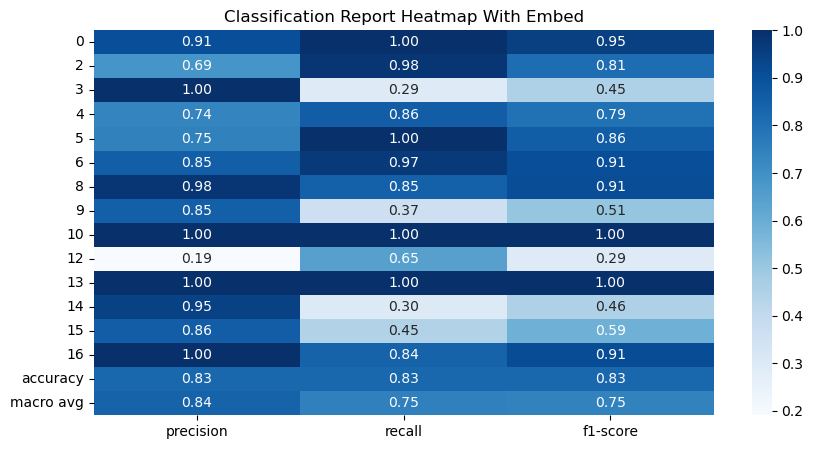

In [58]:
#  Classification report
report_withembed = classification_report(actual_classes_withembed, y_pred_classes_withembed, output_dict=True)
report_withembed_df = pd.DataFrame(report_withembed).transpose()
print(report_withembed_df)

plt.figure(figsize=(10, 5))
sns.heatmap(report_withembed_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues")
plt.title('Classification Report Heatmap With Embed')
plt.show()

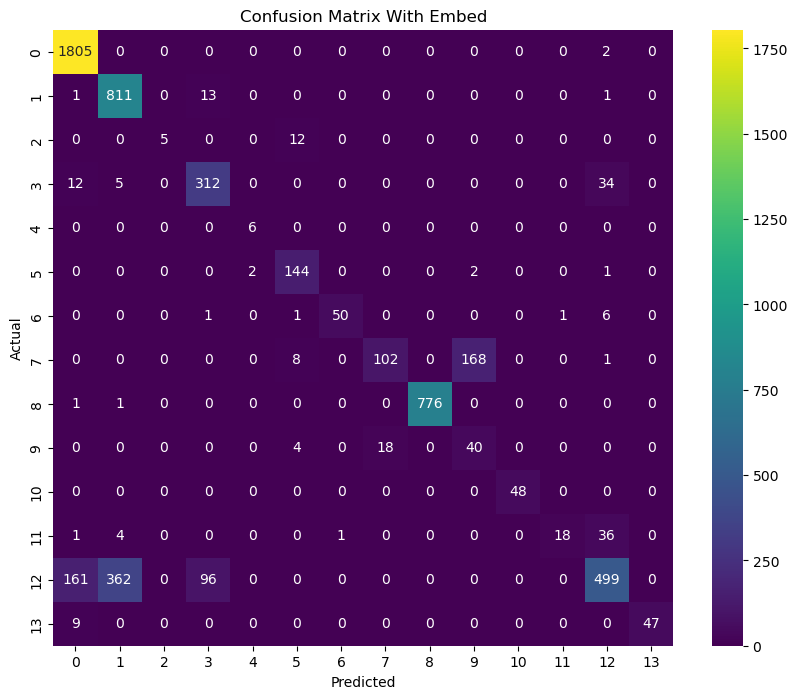

In [59]:
# Confusion Matrix
conf_matrix_withembed = confusion_matrix(actual_classes_withembed, y_pred_classes_withembed)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_withembed, annot=True, fmt='d', cmap='viridis')  # 'd' for integer format
plt.title('Confusion Matrix With Embed')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

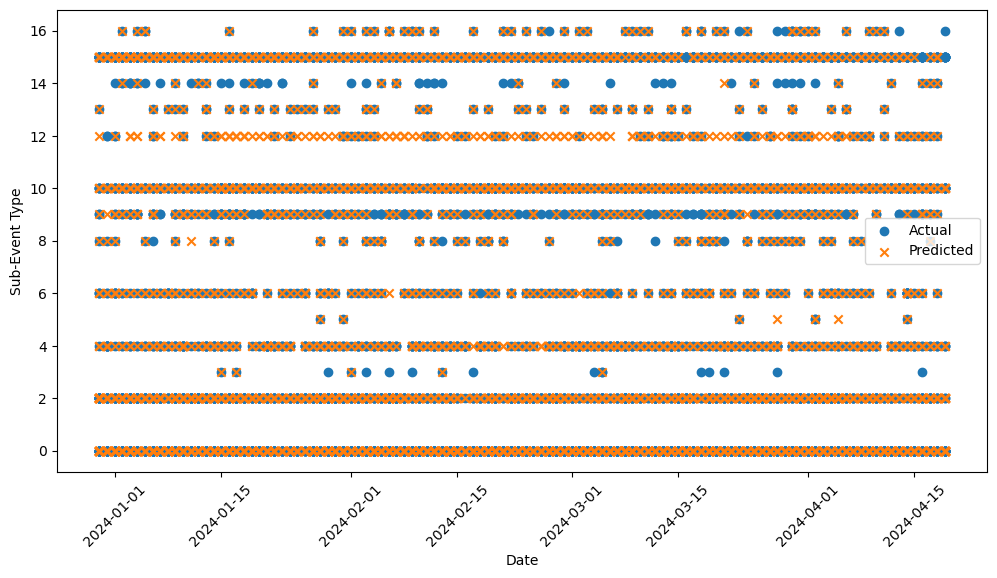

In [60]:
#Attempt to create actual vs. predicted against time

# match length of event_dates_test to actual and y classes
event_dates_test = event_dates_test[-len(actual_classes_withembed):]

all_labels = np.unique(y_train_labels)

# df with event_date, actual labels, and predicted labels
results_withembed_df = pd.DataFrame({
    'event_date': event_dates_test,
    'actual_labels': [all_labels[i] for i in actual_classes_withembed],
    'predicted_labels': [all_labels[i] for i in y_pred_classes_withembed]
})

# converting datetime
results_withembed_df['event_date'] = pd.to_datetime(results_withembed_df['event_date'])

results_withembed_df.set_index('event_date', inplace=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(results_withembed_df.index, results_withembed_df['actual_labels'], label='Actual', marker='o')
ax.scatter(results_withembed_df.index, results_withembed_df['predicted_labels'], label='Predicted', marker='x')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sub-Event Type')
plt.xticks(rotation=45)
plt.show()

In [75]:
log_data_encoded.columns

Index(['event_date', 'year', 'actor1', 'actor2', 'month', 'day',
       'days_since_start', 'rolling_avg_fatalities_7d',
       'cumulative_sub_events', 'cumulative_fatalities',
       ...
       'interaction_36', 'interaction_37', 'interaction_50', 'interaction_56',
       'interaction_57', 'interaction_58', 'interaction_68', 'interaction_77',
       'interaction_80', 'interaction_88'],
      dtype='object', length=122)

In [76]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(log_data_encoded.drop(columns=['event_date'] + sub_event_type_columns),
                                                    log_data_encoded[sub_event_type_columns],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=False)

# Convert the target values to labels
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

In [77]:
#X_train = X_train.astype({col: 'int64' for col in X_train.columns if X_train[col].dtype == 'bool'})
#X_test = X_test.astype({col: 'int64' for col in X_test.columns if X_test[col].dtype == 'bool'})
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print("Labels for Y")
print(y_train_labels.shape)
print(y_test_labels.shape)
print(y_train_labels.dtype)
print(y_test_labels.dtype)
#print(train_idx.shape)
#print(test_idx.shape)
#print(X_train.dtypes)

(22601, 104)
(5651, 104)
(22601, 17)
(5651, 17)
Labels for Y
(22601,)
(5651,)
int64
int64


In [87]:
# Define the function to create the LSTM model
def create_model(n_steps, n_features, n_nodes, dropout_rate, n_classes):
    model = Sequential()
    model.add(LSTM(n_nodes, return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(n_nodes))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [88]:
# Prepare the data for LSTM
n_steps = 24
X_train_reshaped = create_sequences(X_train.to_numpy(), n_steps)
X_test_reshaped = create_sequences(X_test.to_numpy(), n_steps)
y_train_reshaped = y_train_labels[n_steps-1:]
y_test_reshaped = y_test_labels[n_steps-1:]

# configurations
n_classes = len(np.unique(y_train_reshaped))
configs = [
    [X_train_reshaped.shape[2], 50, 0.1, n_classes],  # Testing 10% dropout and 50 neurons
    [X_train_reshaped.shape[2], 50, 0.2, n_classes],  # Testing 20% dropout and 50 neurons
    [X_train_reshaped.shape[2], 100, 0.2, n_classes], # Testing 20% dropout and 100 neurons
    [X_train_reshaped.shape[2], 100, 0.3, n_classes], # Testing 30% dropout and 100 neurons
]

# running model with a specific config
def run_model(config):
    n_features, n_nodes, dropout_rate, n_classes = config
    model = create_model(n_steps, n_features, n_nodes, dropout_rate, n_classes)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train_reshaped, y_train_reshaped, epochs=50, batch_size=64, validation_split=0.1, verbose=1, callbacks=[early_stopping])
    _, accuracy = model.evaluate(X_test_reshaped, y_test_reshaped, verbose=0)
    return accuracy

# grid search over configs
best_accuracy = 0
best_config = None
for config in configs:
    accuracy = run_model(config)
    print(f'Config: {config}, Accuracy: {accuracy:.3f}')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_config = config

print(f'Best Config: {best_config}, Best Accuracy: {best_accuracy:.3f}')


Epoch 1/50


2024-05-04 09:29:35.674409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:29:35.907197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:29:36.111308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:29:36.430564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:29:36.719148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - ETA: 0s - loss: 1.5976 - accuracy: 0.4605

2024-05-04 09:29:44.582901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:29:44.660990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:29:44.799278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 11s 27ms/step - loss: 1.5976 - accuracy: 0.4605 - val_loss: 1.5112 - val_accuracy: 0.4464
Epoch 2/50
318/318 [==============================] - 5s 16ms/step - loss: 0.9454 - accuracy: 0.6917 - val_loss: 1.1713 - val_accuracy: 0.5850
Epoch 3/50
318/318 [==============================] - 5s 15ms/step - loss: 0.7215 - accuracy: 0.7386 - val_loss: 1.3045 - val_accuracy: 0.6444
Epoch 4/50
318/318 [==============================] - 5s 15ms/step - loss: 0.5981 - accuracy: 0.7795 - val_loss: 1.3336 - val_accuracy: 0.6475
Epoch 5/50
318/318 [==============================] - 5s 16ms/step - loss: 0.5061 - accuracy: 0.8215 - val_loss: 0.8821 - val_accuracy: 0.6780
Epoch 6/50
318/318 [==============================] - 5s 15ms/step - loss: 0.4029 - accuracy: 0.8508 - val_loss: 0.7828 - val_accuracy: 0.7183
Epoch 7/50
318/318 [==============================] - 5s 15ms/step - loss: 0.3484 - accuracy: 0.8696 - val_loss: 0.9298 - val_accuracy: 0.7024
Epoch 8/5

2024-05-04 09:31:23.260112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:31:23.578185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:31:23.794012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:31:24.161844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:31:24.574367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - ETA: 0s - loss: 1.7093 - accuracy: 0.4267

2024-05-04 09:31:31.991277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:31:32.073771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:31:32.208913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 11s 26ms/step - loss: 1.7093 - accuracy: 0.4267 - val_loss: 1.3276 - val_accuracy: 0.5097
Epoch 2/50
318/318 [==============================] - 6s 19ms/step - loss: 1.1067 - accuracy: 0.6260 - val_loss: 1.1561 - val_accuracy: 0.5859
Epoch 3/50
318/318 [==============================] - 5s 17ms/step - loss: 0.8599 - accuracy: 0.7109 - val_loss: 0.9427 - val_accuracy: 0.6470
Epoch 4/50
318/318 [==============================] - 5s 17ms/step - loss: 0.6775 - accuracy: 0.7687 - val_loss: 0.9644 - val_accuracy: 0.6377
Epoch 5/50
318/318 [==============================] - 5s 16ms/step - loss: 0.5461 - accuracy: 0.8174 - val_loss: 0.7782 - val_accuracy: 0.7316
Epoch 6/50
318/318 [==============================] - 5s 16ms/step - loss: 0.4638 - accuracy: 0.8464 - val_loss: 0.8649 - val_accuracy: 0.7015
Epoch 7/50
318/318 [==============================] - 6s 18ms/step - loss: 0.3953 - accuracy: 0.8673 - val_loss: 0.7642 - val_accuracy: 0.7068
Epoch 8/5

2024-05-04 09:33:44.527477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:33:44.745909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:33:44.961537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:33:45.349853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:33:45.666745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - ETA: 0s - loss: 1.2846 - accuracy: 0.5654

2024-05-04 09:33:54.273812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:33:54.361030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:33:54.506723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 11s 29ms/step - loss: 1.2846 - accuracy: 0.5654 - val_loss: 0.9742 - val_accuracy: 0.6488
Epoch 2/50
318/318 [==============================] - 6s 18ms/step - loss: 0.6142 - accuracy: 0.8024 - val_loss: 0.8809 - val_accuracy: 0.6532
Epoch 3/50
318/318 [==============================] - 6s 18ms/step - loss: 0.4115 - accuracy: 0.8752 - val_loss: 0.7737 - val_accuracy: 0.6802
Epoch 4/50
318/318 [==============================] - 6s 18ms/step - loss: 0.3154 - accuracy: 0.9006 - val_loss: 0.6470 - val_accuracy: 0.7205
Epoch 5/50
318/318 [==============================] - 6s 18ms/step - loss: 0.2615 - accuracy: 0.9168 - val_loss: 0.9195 - val_accuracy: 0.6851
Epoch 6/50
318/318 [==============================] - 6s 20ms/step - loss: 0.2267 - accuracy: 0.9262 - val_loss: 1.1444 - val_accuracy: 0.6816
Epoch 7/50
318/318 [==============================] - 6s 19ms/step - loss: 0.2021 - accuracy: 0.9324 - val_loss: 0.9910 - val_accuracy: 0.6913
Epoch 8/5

2024-05-04 09:35:19.304706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:35:19.512878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:35:19.706719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:35:20.010126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:35:20.319829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - ETA: 0s - loss: 1.3637 - accuracy: 0.5296

2024-05-04 09:35:27.351436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:35:27.426195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:35:27.584003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 10s 24ms/step - loss: 1.3637 - accuracy: 0.5296 - val_loss: 0.9851 - val_accuracy: 0.6280
Epoch 2/50
318/318 [==============================] - 5s 17ms/step - loss: 0.7590 - accuracy: 0.7358 - val_loss: 1.0238 - val_accuracy: 0.6413
Epoch 3/50
318/318 [==============================] - 6s 17ms/step - loss: 0.5652 - accuracy: 0.8127 - val_loss: 0.6485 - val_accuracy: 0.7405
Epoch 4/50
318/318 [==============================] - 6s 18ms/step - loss: 0.4265 - accuracy: 0.8613 - val_loss: 0.7890 - val_accuracy: 0.7192
Epoch 5/50
318/318 [==============================] - 5s 17ms/step - loss: 0.3991 - accuracy: 0.8699 - val_loss: 0.9615 - val_accuracy: 0.7006
Epoch 6/50
318/318 [==============================] - 5s 17ms/step - loss: 0.2744 - accuracy: 0.9129 - val_loss: 0.5800 - val_accuracy: 0.8003
Epoch 7/50
318/318 [==============================] - 5s 17ms/step - loss: 0.2362 - accuracy: 0.9250 - val_loss: 0.8251 - val_accuracy: 0.7378
Epoch 8/5

In [90]:
# Retraining with best parameters
n_features, n_nodes, dropout_rate, _ = best_config
best_model = create_model(n_steps, n_features, n_nodes, dropout_rate, n_classes)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = best_model.fit(X_train_reshaped, y_train_reshaped, epochs=50, batch_size=64, validation_split=0.1, verbose=1, callbacks=[early_stopping])
loss_noembed, accuracy_noembed = best_model.evaluate(X_test_reshaped, y_test_reshaped)
print(f'Test Accuracy Without Embed: {accuracy_noembed:.2f}')

Epoch 1/50


2024-05-04 09:45:11.923855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:45:12.147076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:45:12.334568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:45:12.761714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:45:13.062625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - ETA: 0s - loss: 1.5360 - accuracy: 0.4958

2024-05-04 09:45:19.514297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:45:19.596000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:45:19.724552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 9s 22ms/step - loss: 1.5360 - accuracy: 0.4958 - val_loss: 1.3448 - val_accuracy: 0.4907
Epoch 2/50
318/318 [==============================] - 5s 16ms/step - loss: 0.9084 - accuracy: 0.7137 - val_loss: 1.1201 - val_accuracy: 0.5642
Epoch 3/50
318/318 [==============================] - 5s 16ms/step - loss: 0.6633 - accuracy: 0.7854 - val_loss: 0.8968 - val_accuracy: 0.6143
Epoch 4/50
318/318 [==============================] - 5s 16ms/step - loss: 0.5084 - accuracy: 0.8341 - val_loss: 0.8376 - val_accuracy: 0.6794
Epoch 5/50
318/318 [==============================] - 5s 16ms/step - loss: 0.3996 - accuracy: 0.8771 - val_loss: 0.6479 - val_accuracy: 0.7276
Epoch 6/50
318/318 [==============================] - 5s 16ms/step - loss: 0.3233 - accuracy: 0.9008 - val_loss: 0.6298 - val_accuracy: 0.7130
Epoch 7/50
318/318 [==============================] - 5s 16ms/step - loss: 0.2792 - accuracy: 0.9113 - val_loss: 0.7505 - val_accuracy: 0.7360
Epoch 8/50

In [91]:
# Predictions
y_pred_noembed = best_model.predict(X_test_reshaped)
y_pred_classes_noembed = np.argmax(y_pred_noembed, axis=1)

# Actual class
actual_classes_noembed = y_test_reshaped

# Metrics
mae_LSTM_noembed = mean_absolute_error(actual_classes_noembed, y_pred_classes_noembed)
print(f'Mean Absolute Error LSTM: {mae_LSTM_noembed:.2f}')

mse_LSTM_noembed = mean_squared_error(actual_classes_noembed, y_pred_classes_noembed)
print(f'Mean Squared Error LSTM: {mse_LSTM_noembed:.2f}')

rmse_LSTM_noembed = np.sqrt(mse_LSTM_noembed)
print(f'Root Mean Squared Error LSTM: {rmse_LSTM_noembed:.2f}')

2024-05-04 09:47:22.089581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:47:22.145505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 09:47:22.279221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


176/176 [==============================] - 1s 5ms/step
Mean Absolute Error LSTM: 3.41
Mean Squared Error LSTM: 45.09
Root Mean Squared Error LSTM: 6.72


In [93]:
#Actual vs Pred
predicted_labels_noembed = [sub_event_type_labels[i] for i in y_pred_classes_noembed]
actual_labels_noembed = [sub_event_type_labels[i] for i in actual_classes_noembed]

for actual, predicted in zip(actual_labels_noembed[:10], predicted_labels_noembed[:10]):
    print(f"Actual: {actual}, Predicted: {predicted}")

Actual: Looting/property destruction, Predicted: Looting/property destruction
Actual: Disrupted weapons use, Predicted: Disrupted weapons use
Actual: Shelling/artillery/missile attack, Predicted: Attack
Actual: Grenade, Predicted: Disrupted weapons use
Actual: Armed clash, Predicted: Armed clash
Actual: Mob violence, Predicted: Mob violence
Actual: Mob violence, Predicted: Mob violence
Actual: Mob violence, Predicted: Mob violence
Actual: Armed clash, Predicted: Armed clash
Actual: Armed clash, Predicted: Armed clash


In [94]:
# Showing errors
errors_noembed = np.where(y_pred_classes_noembed != actual_classes_noembed)[0]
print(f'Number of errors Without Embed: {len(errors_noembed)} / {len(actual_classes_noembed)}')
for i in errors_noembed[:10]:  # first 10
    print(f'Index: {i}, Predicted: {y_pred_classes_noembed[i]}, Actual: {actual_classes_noembed[i]}')


Number of errors Without Embed: 1991 / 5628
Index: 2, Predicted: 4, Actual: 15
Index: 3, Predicted: 6, Actual: 8
Index: 11, Predicted: 0, Actual: 15
Index: 13, Predicted: 0, Actual: 15
Index: 17, Predicted: 0, Actual: 15
Index: 18, Predicted: 0, Actual: 15
Index: 19, Predicted: 0, Actual: 15
Index: 20, Predicted: 0, Actual: 15
Index: 30, Predicted: 4, Actual: 15
Index: 31, Predicted: 4, Actual: 15


/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

              precision    recall  f1-score      support
0              0.674766  0.998893  0.805444  1807.000000
2              0.583396  0.935835  0.718735   826.000000
3              0.000000  0.000000  0.000000    17.000000
4              0.089286  0.013774  0.023866   363.000000
5              0.000000  0.000000  0.000000     6.000000
6              0.551852  1.000000  0.711217   149.000000
8              0.055556  0.016949  0.025974    59.000000
9              0.287500  0.082437  0.128134   279.000000
10             1.000000  1.000000  1.000000   778.000000
12             0.019157  0.080645  0.030960    62.000000
13             1.000000  0.812500  0.896552    48.000000
14             1.000000  0.016667  0.032787    60.000000
15             0.166667  0.001789  0.003540  1118.000000
16             0.495575  1.000000  0.662722    56.000000
accuracy       0.646233  0.646233  0.646233     0.646233
macro avg      0.423125  0.425678  0.359995  5628.000000
weighted avg   0.533154  0.6462

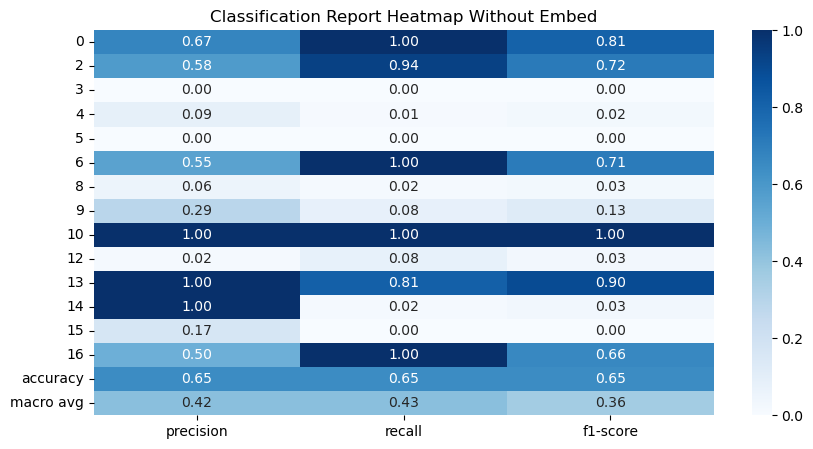

In [95]:
# Classification report
report_noembed = classification_report(actual_classes_noembed, y_pred_classes_noembed, output_dict=True)
report_noembed_df = pd.DataFrame(report_noembed).transpose()
print(report_noembed_df)

plt.figure(figsize=(10, 5))
sns.heatmap(report_noembed_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues")
plt.title('Classification Report Heatmap Without Embed')
plt.show()

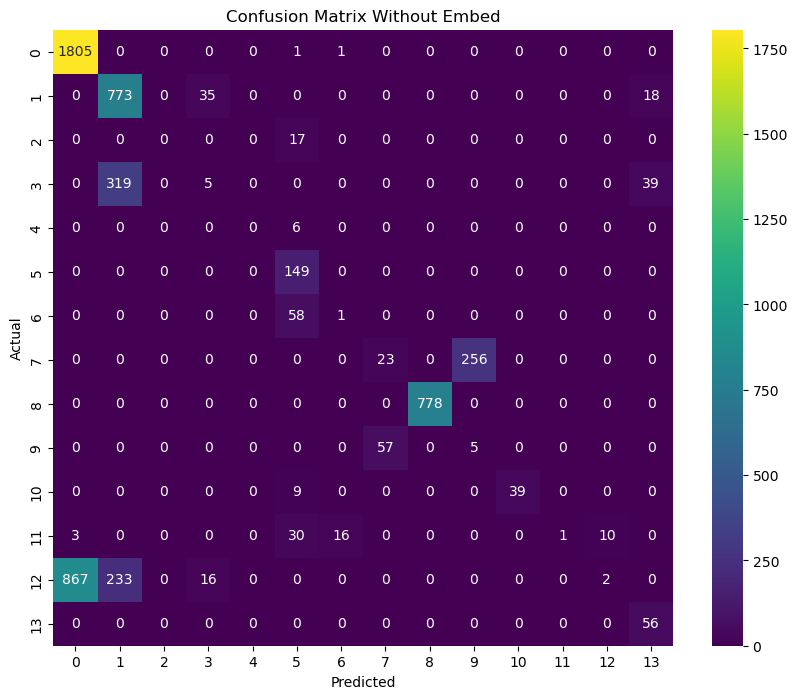

In [96]:
# Confusion Matrix
conf_matrix_noembed = confusion_matrix(actual_classes_noembed, y_pred_classes_noembed)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_noembed, annot=True, fmt='d', cmap='viridis')  # 'd' for integer format
plt.title('Confusion Matrix Without Embed')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
#VAR Model?

#flattening for data purposes
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

model = VAR(X_train_flat)
model_fitted = model.fit()


In [ ]:
predictions = model_fitted.forecast(model_fitted.y, steps=len(X_val_flat))

mse = mean_squared_error(X_val_flat, predictions)
print("Mean Squared Error:", mse)
plt.plot(X_val_flat, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()